# References:
1. https://www.kaggle.com/hely333/eda-regression
2. http://rstudio-pubs-static.s3.amazonaws.com/142772_218508e3f94e4419944e9104505b6f17.html
3. http://blog.kaggle.com/2016/01/22/rossmann-store-sales-winners-interview-3rd-place-cheng-gui/
4. https://www.kaggle.com/c/rossmann-store-sales/discussion/17974
5. https://jikeme.com/rossmann-store-sales-winners-interview-3rd-place-neokami-inc
6. https://github.com/li-kai/rossman-store-sales/blob/master/hw3-rossman.ipynb
7. http://blog.kaggle.com/2015/12/21/rossmann-store-sales-winners-interview-1st-place-gert/
8. http://cs229.stanford.edu/proj2015/218_report.pdf
9. http://rohanrao91.blogspot.com/2015/12/rossmann-store-sales.html
10. https://mabrek.github.io/blog/kaggle-forecasting/
11. https://arxiv.org/pdf/1604.06737.pdf
12. http://www.johnatate.com/learning-from-the-best-rossman-sales-kaggle-winners.html
13. https://www.kaggle.com/abhilashawasthi/xgb-rossmann
14. https://www.kaggle.com/c/rossmann-store-sales/discussion/18024
15. https://rpubs.com/gpetho/142772

# Dataset
1. https://www.kaggle.com/marcinex1423/salesdb-grocery#salesDB_grocery_market.zip
1. https://www.kaggle.com/fayomi/advertising
2. https://www.kaggle.com/harlfoxem/housesalesprediction
3. https://github.com/awesomedata/awesome-public-datasets
4. https://www.kdnuggets.com/datasets/index.html
5. https://www.kaggle.com/devashish0507/big-mart-sales-prediction
6. https://archive.ics.uci.edu/ml/datasets/Statlog+(Vehicle+Silhouettes)

# 0.0 IMPORTS
---

In [3]:
import pandas                                                 as pd
import seaborn                                                as sns
import xgboost                                                as xgb
import warnings                               
import statsmodels.api                                        as sm
import statsmodels.formula.api                                as smf

from time                      import time
from boruta                    import BorutaPy
from matplotlib                import pyplot                  as plt
from IPython.core.display      import HTML

from sklearn.svm               import SVR
from sklearn.metrics           import mean_absolute_error, mean_squared_error
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing     import LabelEncoder
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import RFECV

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [62]:
# --- Jupyter Notebook Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
def rmspe( y, yhat ):
    return np.sqrt( np.mean( ( yhat/y-1) **2 ) )


def rmspe_xg( yhat, y ):
    y = np.expm1( y.get_label() )
    yhat = np.expm1( yhat )
    return 'rmspe', rmspe( y, yhat )


def ml_error( model_name, y_test, yhat ):
    error = rmspe( y_test, yhat )
    mae = mean_absolute_error( y_test, yhat )
    rmse = np.sqrt( mean_squared_error( y_test, yhat ) )
    
    return pd.DataFrame( {'Model':model_name, 'RMSPE':error, 'RMSE':rmse, 'MAE':mae}, index=[0] )

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [6]:
df_sales_raw = pd.read_csv( '../data/train.csv' )
df_stores_raw = pd.read_csv( '../data/store.csv' )

# Merge dataset
df_raw = pd.merge( df_sales_raw, df_stores_raw, on='Store', how='left' )

# 1.0. DATA PREPARATION
---

In [7]:
df_raw.sample(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
993558,879,2,2013-01-22,4692,389,1,1,0,0,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
483471,347,4,2014-04-24,4104,331,1,0,0,1,d,c,9360.0,7.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


## 1.1. Rename Attributes

In [8]:
df1 = df_raw.copy()

In [9]:
# new columns name
new_cols=['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
          'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval']

# rename
df1.columns = new_cols

In [10]:
df1.sample(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
634810,46,1,2013-12-09,4512,625,1,0,0,0,c,a,1200.0,9.0,2005.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
363368,917,1,2014-08-18,10103,1028,1,1,0,1,a,a,7240.0,2.0,2010.0,0,NaN,NaN,NaN


# 2.0. DESCRIBE DATA
---

In [11]:
df2 = df1.copy()

## 2.1. Data Dimensions

In [12]:
print( 'Number of Rows: {}'.format( df2.shape[0] ) )
print( 'Number of Columns: {}'.format( df2.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 2.2. Data Type Attributes

In [13]:
df2.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [14]:
# convert to datetime
df2['date'] = pd.to_datetime( df2['date'] )

df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.3. Number of NA

In [15]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
store                           1017209 non-null int64
day_of_week                     1017209 non-null int64
date                            1017209 non-null datetime64[ns]
sales                           1017209 non-null int64
customers                       1017209 non-null int64
open                            1017209 non-null int64
promo                           1017209 non-null int64
state_holiday                   1017209 non-null object
school_holiday                  1017209 non-null int64
store_type                      1017209 non-null object
assortment                      1017209 non-null object
competition_distance            1014567 non-null float64
competition_open_since_month    693861 non-null float64
competition_open_since_year     693861 non-null float64
promo2                          1017209 non-null int64
promo2_since_week               509178 non-nul

## 2.4. Treat NA columns

In [17]:
df2.sample( 2 )

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
61877,553,6,2015-06-06,9098,882,1,0,0,0,c,a,3040.0,9.0,2002.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
6910,221,6,2015-07-25,5319,496,1,0,0,0,d,c,13530.0,9.0,2013.0,0,NaN,NaN,NaN


In [18]:
# promo2_since_year
df2['promo2_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo2_since_week
df2['promo2_since_week'] = df2.apply( lambda x: x['date'].weekofyear if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# competition_distance
df2['competition_distance'] = df2['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df2['competition_open_since_month'] = df2.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 ) 

# competition_open_since_year
df2['competition_open_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo_interval
## fill na with 0
df2.fillna( 0, inplace=True )
# if date is in the promo interval, there is promo.
monthmap = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
df2['month_map'] = df2['date'].dt.month.map( monthmap )
df2['is_promo'] = df2[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [19]:
df2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 2.5. Change the Columns Data Types

In [20]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
# change competition data - Month and Year
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype( int )
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype( int )

# change competition data - Week
df2['promo2_since_week'] = df2['promo2_since_week'].astype( int )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( int )

In [22]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.6. Descriptive statistics

In [23]:
# separate the categorical from numerical features
num_attributes = df2.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
dat_attributes = df2.select_dtypes( include=['datetime64[ns]'] )

print( 'Num of Categorical: {}'.format( cat_attributes.shape[1] ) )
print( 'Num of Numerical: {}'.format( num_attributes.shape[1] ) )
print( 'Num of Date: {}'.format( dat_attributes.shape[1] ) )

Num of Categorical: 5
Num of Numerical: 14
Num of Date: 1


### 2.6.1. Central Tendency and Dispersion 

#### 2.6.1.1. Numerical Attributes

In [24]:
# Meausure of Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( median ) ).T


# Dispersion
d1 = pd.DataFrame( num_attributes.apply( std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T

m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard_deviation', 'kurtosis', 'skew']

m

,attributes,min,max,range,mean,median,standard_deviation,kurtosis,skew
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.200524,-0.000955
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-1.246873,0.001593
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.778375,0.641460
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,7.091773,1.598650
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.090723,-1.758045
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,-1.762018,0.487838
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,0.815154,1.677842
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,147.789712,10.242344
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.232607,-0.042076
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,124.071304,-7.235657


### 2.6.1.2. Categorical Attributes

In [25]:
c = pd.DataFrame( cat_attributes.apply( lambda x: x.unique().shape[0], axis=0 ).reset_index() )
c.columns = ['Columns Names', 'Number of Levels']
print( c )

    Columns Names  Number of Levels
0   state_holiday                 5
1      store_type                 4
2      assortment                 3
3  promo_interval                 4
4       month_map                12


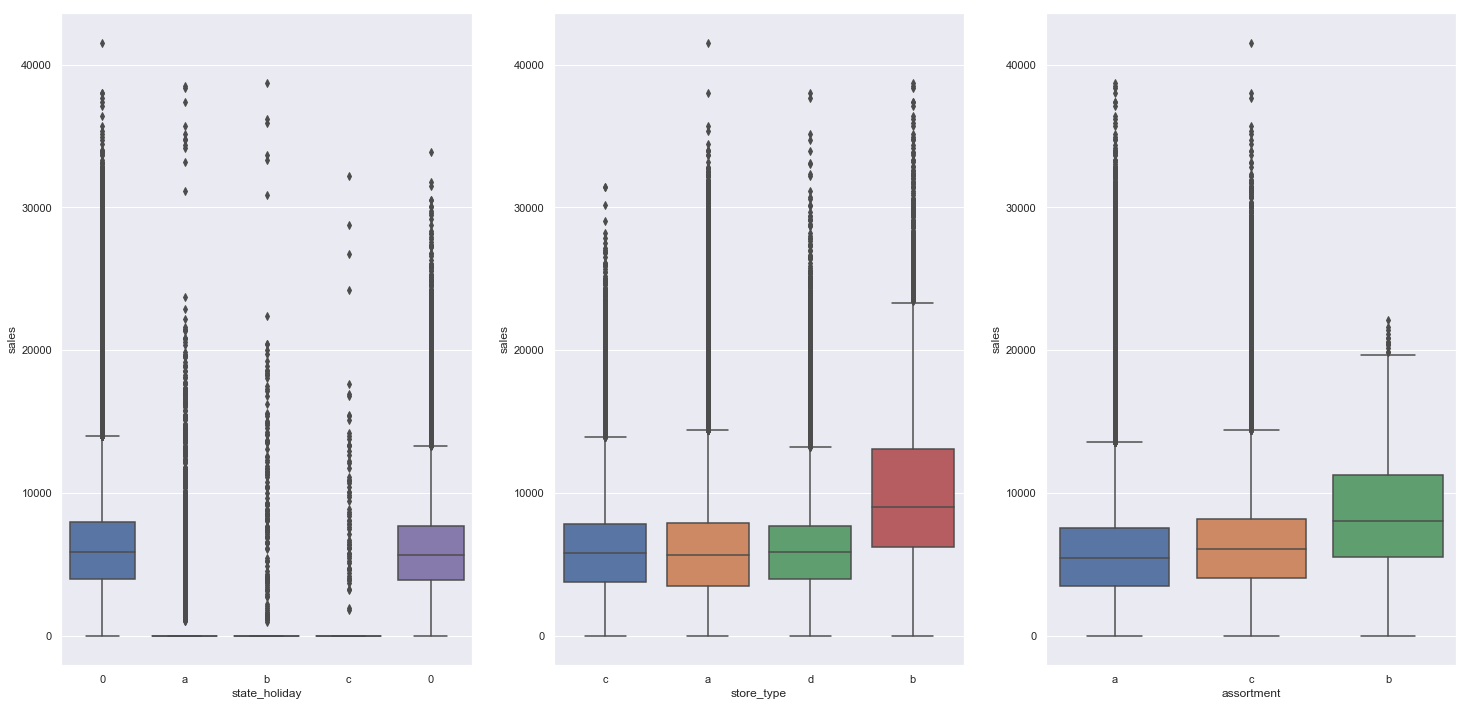

In [26]:
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=df2 );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=df2 );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=df2 );

# 3.0. FEATURE ENGINEERING
---

In [27]:
df3 = df2.copy()

## 3.1. Feature Creation

In [28]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear

# state_holiday
df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 

# assortment
df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# competition weeks
df3['month_of_competition'] = 12*( df3['year'] - df3['competition_open_since_year'] ) + ( df3['month'] - df3['competition_open_since_month'] )
df3['month_of_competition'] = df3['month_of_competition'].apply( lambda x: x if x > 0 else 0 )

# promomotion weeks
df3['month_of_promo'] = 12*( df3['year'] - df3['promo2_since_year'] ) + ( df3['week_of_year'] - df3['promo2_since_week'] )/4
df3['month_of_promo'] = df3['month_of_promo'].apply( lambda x: x if x > 0 else 0 )

# 4.0. SELECT FEATURES
---

In [29]:
df4 = df3.copy()

## 4.1. Filtering Rows

In [30]:
# only use data of Sales > 0 and Open is 1
df4 = df4[ (df4['open'] != 0) & (df4['sales'] > 0) ]

## 4.2. Selecting Columns

**Columns to Drop**
1. **date**: foram derivados novas features da variavel date
2. **customers**: voce nao sabe o numero de clientes no momento da predicao
3. **open**: todas as linhas sao open
4. **promo interval**: foram derivadas novas features
5. **month map**: variável auxiliar

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

# drop columns
df4 = df4.drop( cols_drop, axis=1 )

In [32]:
df4.head(3)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,month_of_competition,month_of_promo
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,82,0.00
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,92,64.50
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,103,52.25


# 5.0. EXPLORATION DATA ANALYSIS 
---

In [33]:
df5 = df4.copy()

In [34]:
# separate the categorical from numerical features
num_attributes = df5.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df5.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
dat_attributes = df5.select_dtypes( include=['datetime64[ns]'] )

print( 'Num of Categorical: {}'.format( cat_attributes.shape[1] ) )
print( 'Num of Numerical: {}'.format( num_attributes.shape[1] ) )
print( 'Num of Date: {}'.format( dat_attributes.shape[1] ) )

Num of Categorical: 3
Num of Numerical: 18
Num of Date: 1


## 5.1. Univariate Analysis

### 5.1.1. Response Variable

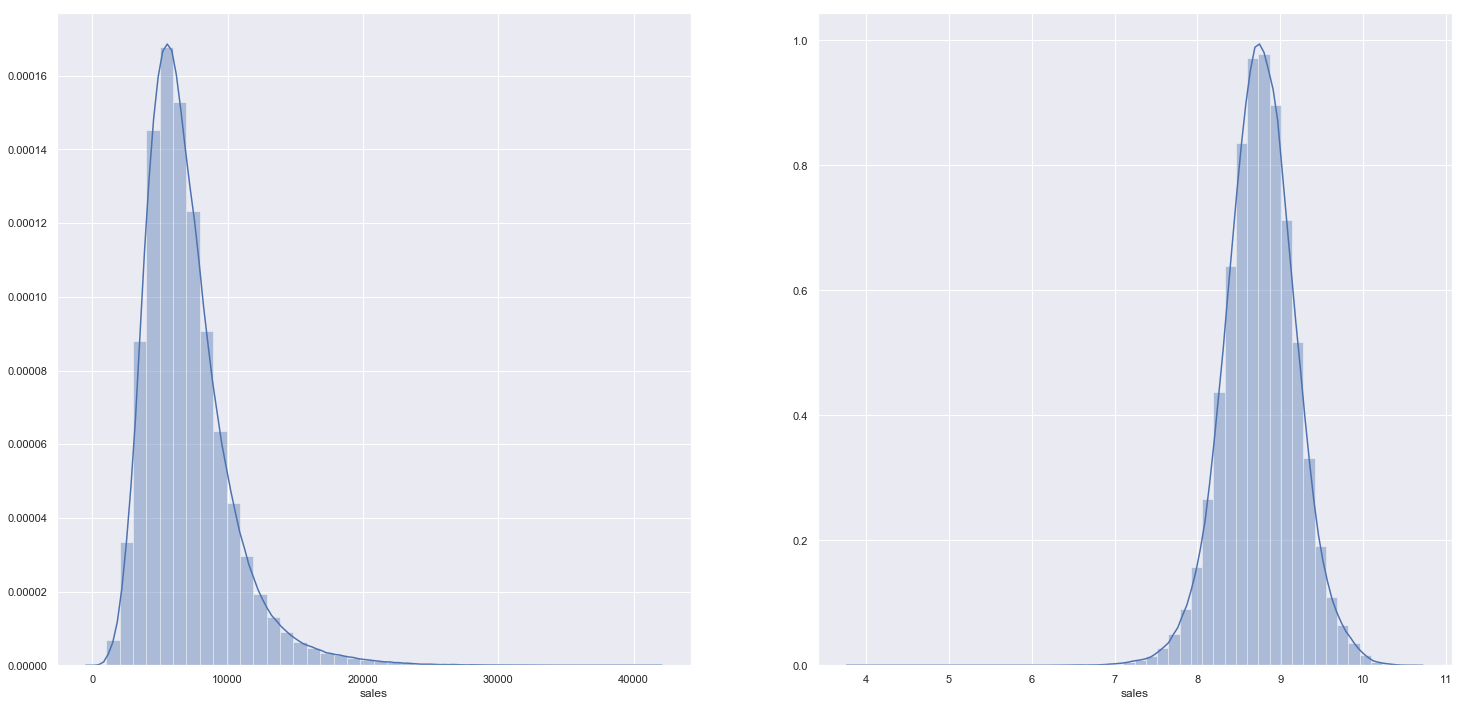

In [35]:
plt.subplot( 1, 2, 1 )
sns.distplot( df5['sales'], kde=True, bins=42 )

plt.subplot( 1, 2, 2 )
sns.distplot( np.log1p( df5['sales'] ), kde=True )

### 5.1.2. Numerical Predictors

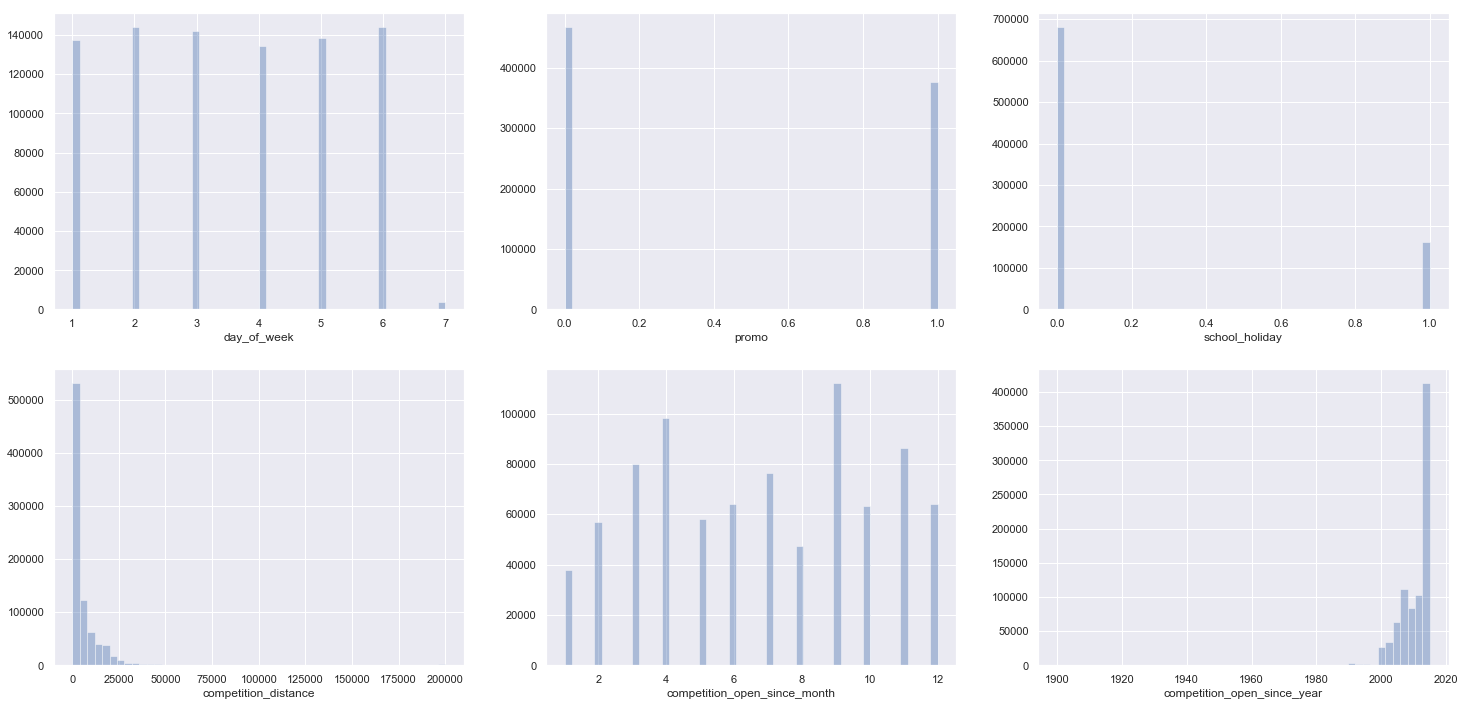

In [36]:
plt.subplot( 2, 3, 1 )
sns.distplot( df5['day_of_week'], kde=False );

plt.subplot( 2, 3, 2 )
sns.distplot( df5['promo'], kde=False );

plt.subplot( 2, 3, 3 )
sns.distplot( df5['school_holiday'], kde=False );

plt.subplot( 2, 3, 4 )
sns.distplot( df5['competition_distance'], kde=False );

plt.subplot( 2, 3, 5 )
sns.distplot( df5['competition_open_since_month'], kde=False );

plt.subplot( 2, 3, 6 )
sns.distplot( df5['competition_open_since_year'], kde=False );

In [37]:
num_attributes.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,month_of_competition,month_of_promo
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,82,0.00
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,92,64.50
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,103,52.25
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,70,0.00
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,3,0.00


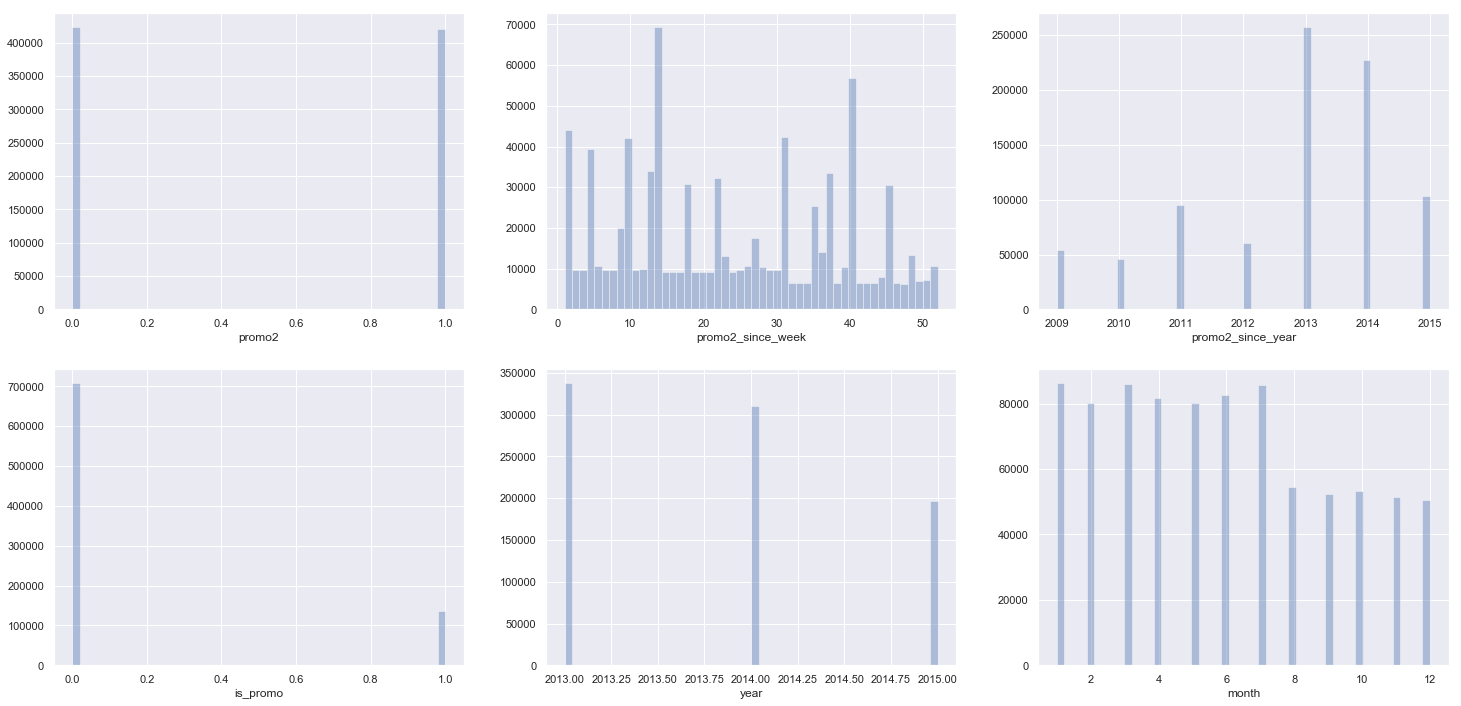

In [38]:
plt.subplot( 2, 3, 1 )
sns.distplot( df5['promo2'], kde=False );

plt.subplot( 2, 3, 2 )
sns.distplot( df5['promo2_since_week'], kde=False );

plt.subplot( 2, 3, 3 )
sns.distplot( df5['promo2_since_year'], kde=False );

plt.subplot( 2, 3, 4 )
sns.distplot( df5['is_promo'], kde=False );

plt.subplot( 2, 3, 5 )
sns.distplot( df5['year'], kde=False );

plt.subplot( 2, 3, 6 )
sns.distplot( df5['month'], kde=False );

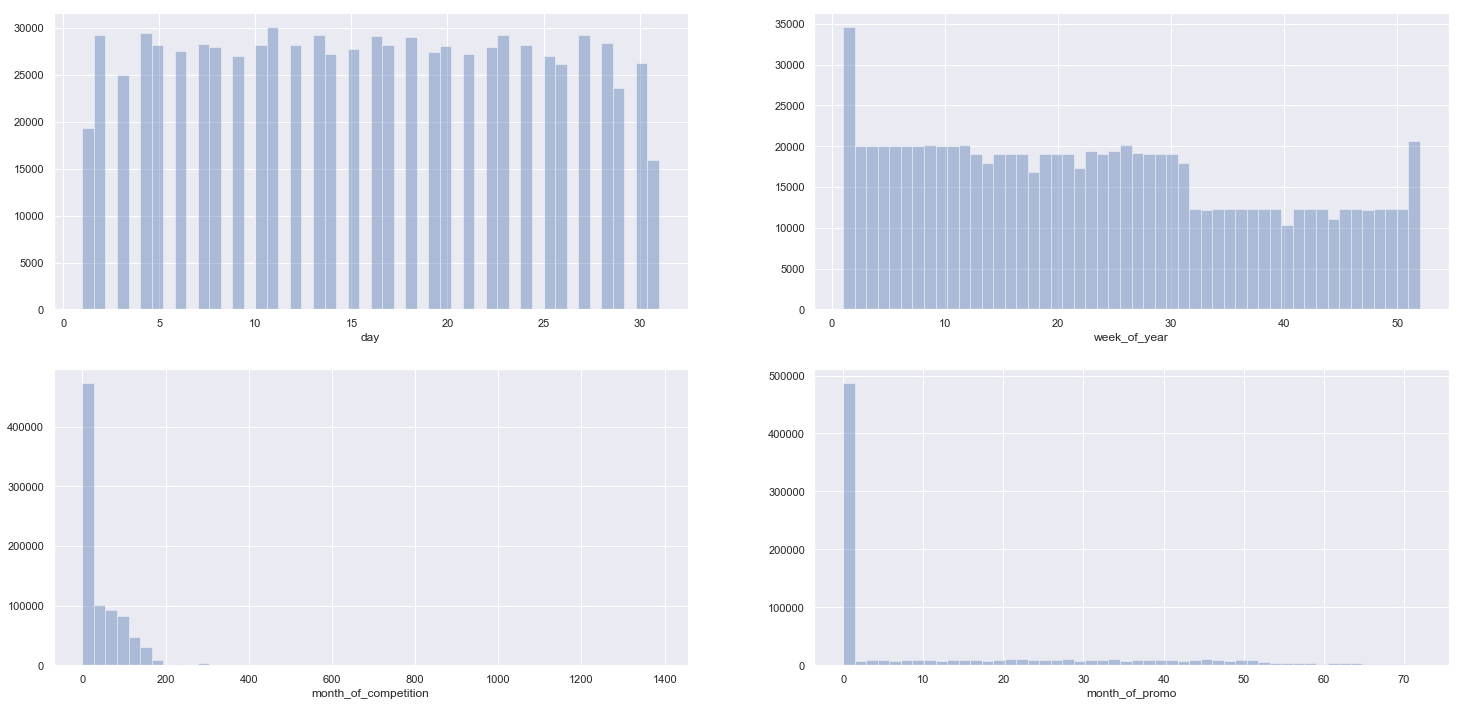

In [39]:
plt.subplot( 2, 2, 1 )
sns.distplot( df5['day'], kde=False );

plt.subplot( 2, 2, 2 )
sns.distplot( df5['week_of_year'], kde=False );

plt.subplot( 2, 2, 3 )
sns.distplot( df5['month_of_competition'], kde=False );

plt.subplot( 2, 2, 4 )
sns.distplot( df5['month_of_promo'], kde=False );

### 5.1.3. Categorical Predictors

In [40]:
cat_attributes.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


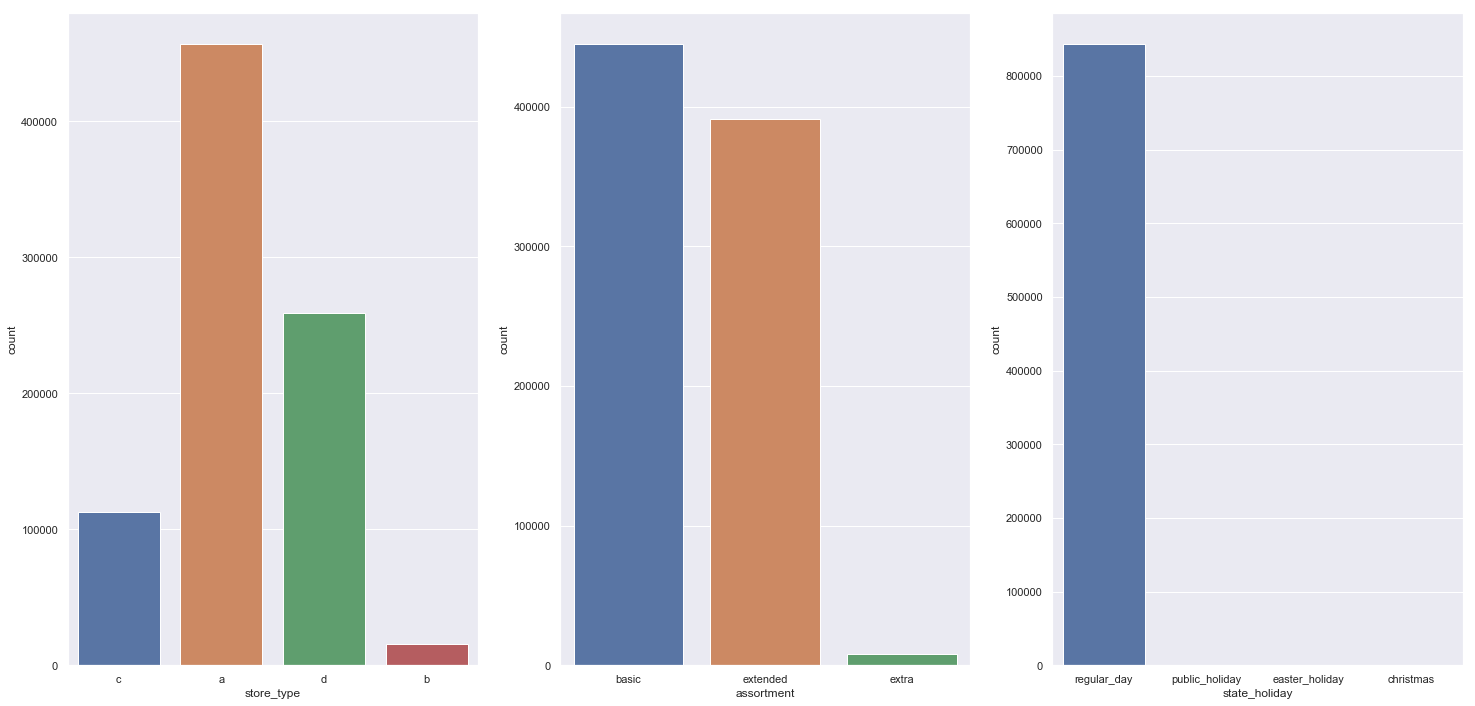

In [41]:
plt.subplot( 1, 3, 1 )
sns.countplot( x='store_type', data=df5 )

plt.subplot( 1, 3, 2 )
sns.countplot( x='assortment', data=df5 )

plt.subplot( 1, 3, 3 )
sns.countplot( x='state_holiday', data=df5 )

## 5.2. Bivariate Analysis

### 5.2.1. Numerical Predictors

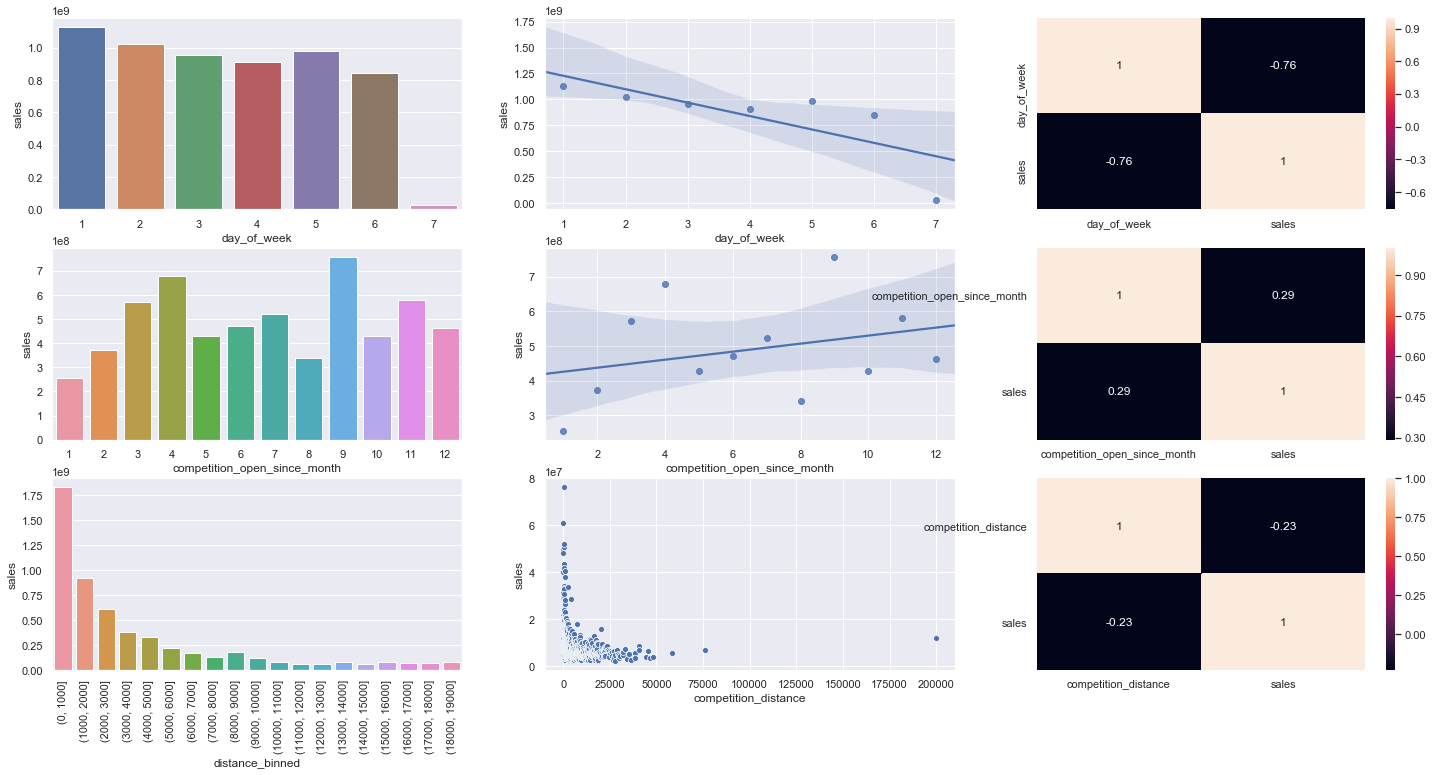

In [42]:
# -------------------
# day of week
# -------------------
aux1 = df5[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# ----------------------------
# competition open since month
# ----------------------------
aux3 = df5[['competition_open_since_month', 'sales']].groupby( 'competition_open_since_month' ).sum().reset_index()
cor3 = aux3.corr( method='pearson' )

plt.subplot( 3, 3, 4 )
sns.barplot( x='competition_open_since_month', y='sales', data=aux3 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='competition_open_since_month', y='sales', data=aux3 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor3, annot=True )

# -------------------
# competition distance
# -------------------
aux2 = df5[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
cor2 = aux2.corr( method='pearson' )

bins = list( np.arange( 0, 20000, 1000 ) )
aux2['distance_binned'] = pd.cut( aux2['competition_distance'], bins=bins )
aux3 = aux2[['distance_binned', 'sales']].groupby( 'distance_binned' ).sum().reset_index()

plt.subplot( 3, 3, 7 )
sns.barplot( x='distance_binned', y='sales', data=aux3 )
plt.xticks( rotation=90 )

plt.subplot( 3, 3, 8 )
sns.scatterplot( x='competition_distance', y='sales', data=aux2 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor2, annot=True )


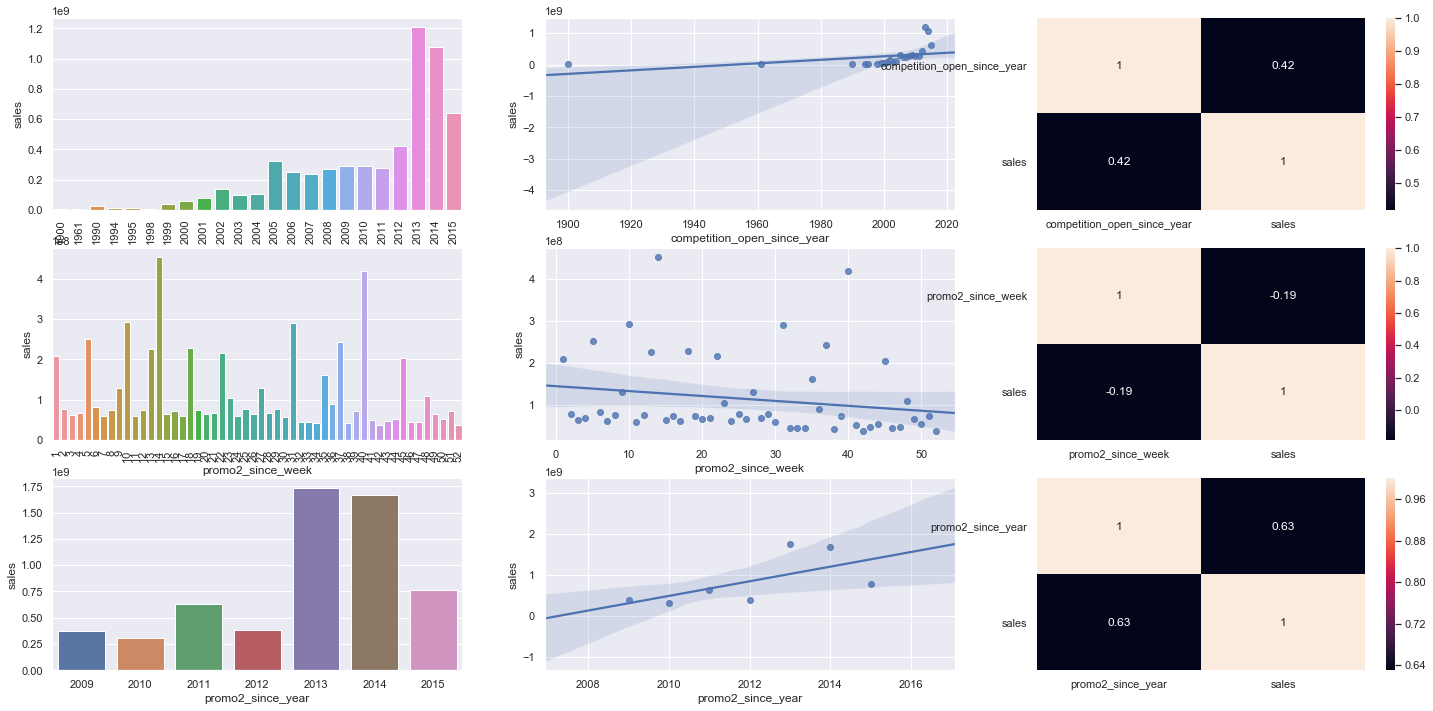

In [43]:
# ----------------------------
# competition open since year
# ----------------------------
aux1 = df5[['competition_open_since_year', 'sales']].groupby( 'competition_open_since_year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )

plt.subplot( 3, 3, 1 )
sns.barplot( x='competition_open_since_year', y='sales', data=aux1 )
plt.xticks( rotation=90 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='competition_open_since_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# -------------------
# promo2 since week
# -------------------
aux1 = df5[['promo2_since_week', 'sales']].groupby( 'promo2_since_week' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 4 )
sns.barplot( x='promo2_since_week', y='sales', data=aux1 )
plt.xticks( rotation=90 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='promo2_since_week', y='sales', data=aux1 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor1, annot=True )

# -------------------
# promo2 since year
# -------------------
aux1 = df5[['promo2_since_year', 'sales']].groupby( 'promo2_since_year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 7 )
sns.barplot( x='promo2_since_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 8 )
sns.regplot( x='promo2_since_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor1, annot=True )


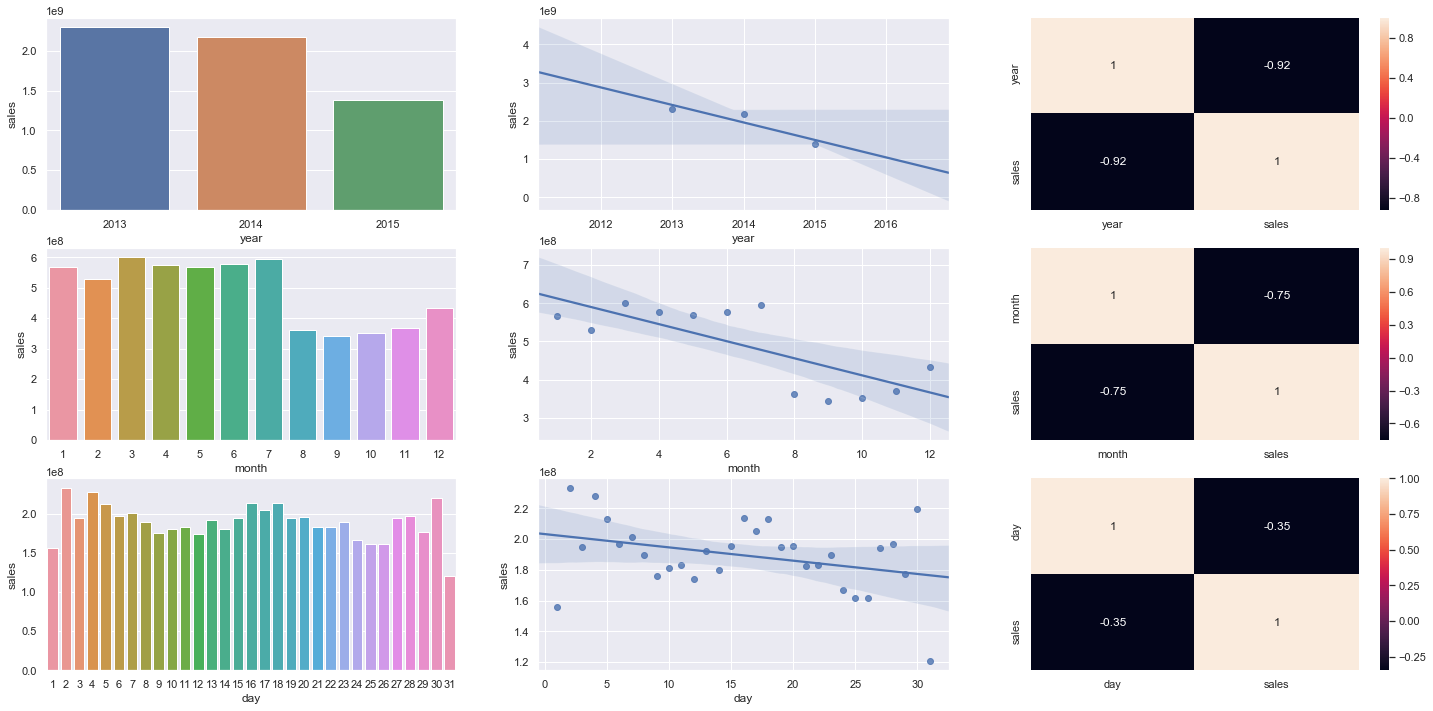

In [44]:
# ----------------------------
# year
# ----------------------------
aux1 = df5[['year', 'sales']].groupby( 'year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )

plt.subplot( 3, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# -------------------
# month
# -------------------
aux1 = df5[['month', 'sales']].groupby( 'month' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 4 )
sns.barplot( x='month', y='sales', data=aux1 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='month', y='sales', data=aux1 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor1, annot=True )

# -------------------
# day
# -------------------
aux1 = df5[['day', 'sales']].groupby( 'day' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 7 )
sns.barplot( x='day', y='sales', data=aux1 )

plt.subplot( 3, 3, 8 )
sns.regplot( x='day', y='sales', data=aux1 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor1, annot=True )


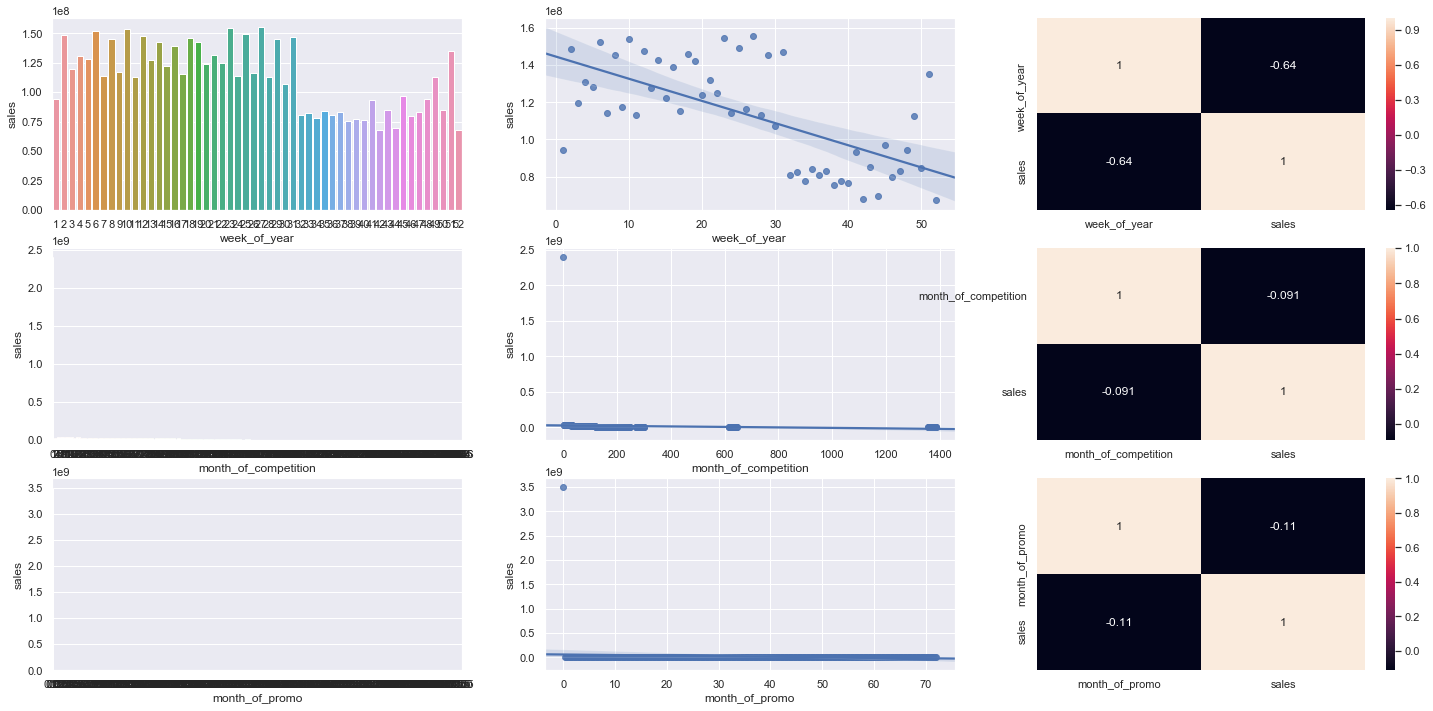

In [45]:
# ----------------------------
# week_of_year
# ----------------------------
aux1 = df5[['week_of_year', 'sales']].groupby( 'week_of_year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )

plt.subplot( 3, 3, 1 )
sns.barplot( x='week_of_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='week_of_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# -------------------
# month of competition
# -------------------
aux1 = df5[['month_of_competition', 'sales']].groupby( 'month_of_competition' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 4 )
sns.barplot( x='month_of_competition', y='sales', data=aux1 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='month_of_competition', y='sales', data=aux1 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor1, annot=True )

# -------------------
# month_of_promo
# -------------------
aux1 = df5[['month_of_promo', 'sales']].groupby( 'month_of_promo' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 7 )
sns.barplot( x='month_of_promo', y='sales', data=aux1 )

plt.subplot( 3, 3, 8 )
sns.regplot( x='month_of_promo', y='sales', data=aux1 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor1, annot=True )


### 5.2.2. Categorical Predictors

In [47]:
cat_attributes.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


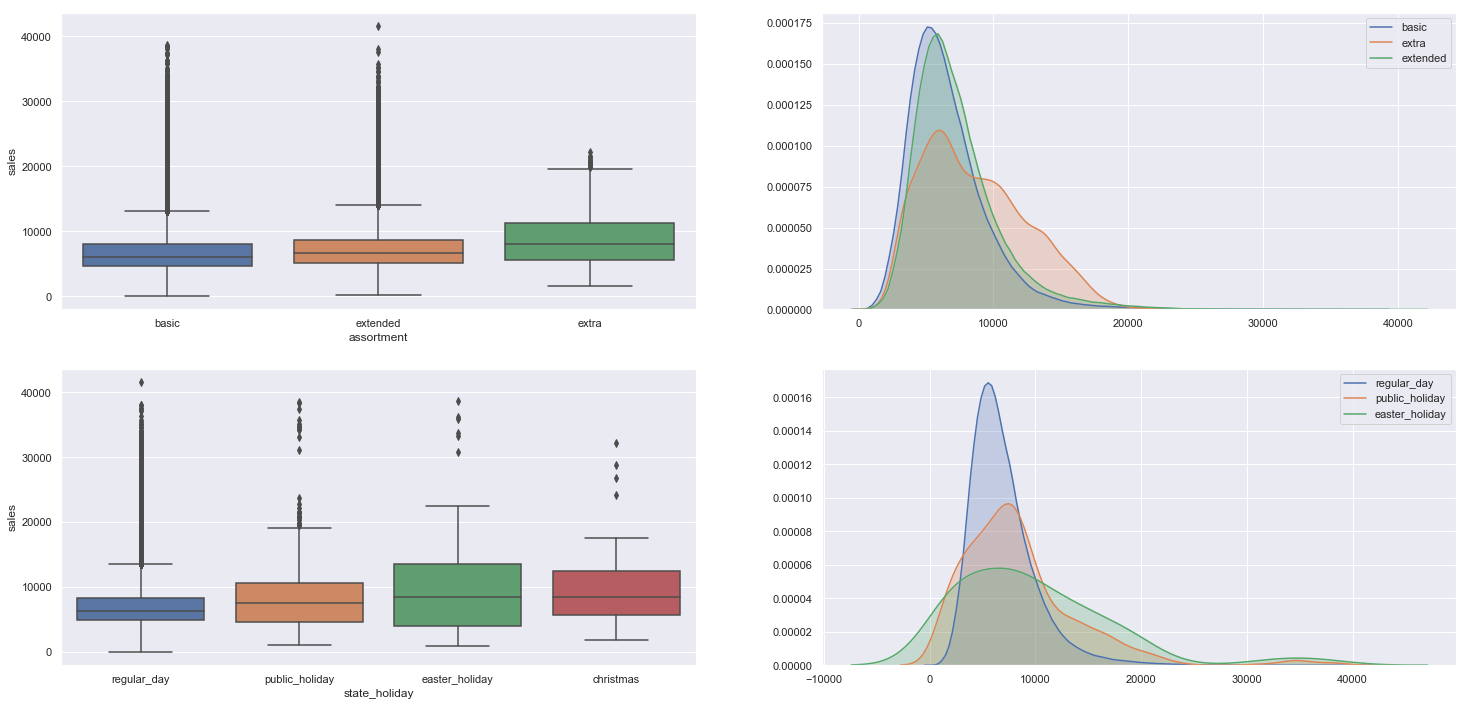

In [48]:
# Assortment X Sales
plt.subplot( 2, 2, 1 )
sns.boxplot( x='assortment', y='sales', data=df5 )

plt.subplot( 2, 2, 2 )
sns.kdeplot( df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True );
sns.kdeplot( df5[df5['assortment'] == 'extra']['sales'], label='extra', shade=True );
sns.kdeplot( df5[df5['assortment'] == 'extended']['sales'], label='extended', shade=True );

# State Holiday X Sales
plt.subplot( 2, 2, 3 )
sns.boxplot( x='state_holiday', y='sales', data=df5 )

plt.subplot( 2, 2, 4 )
sns.kdeplot( df5[df5['state_holiday'] == 'regular_day']['sales'], label='regular_day', shade=True );
sns.kdeplot( df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True );
sns.kdeplot( df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True );

## 5.3. Multivariate Analysis

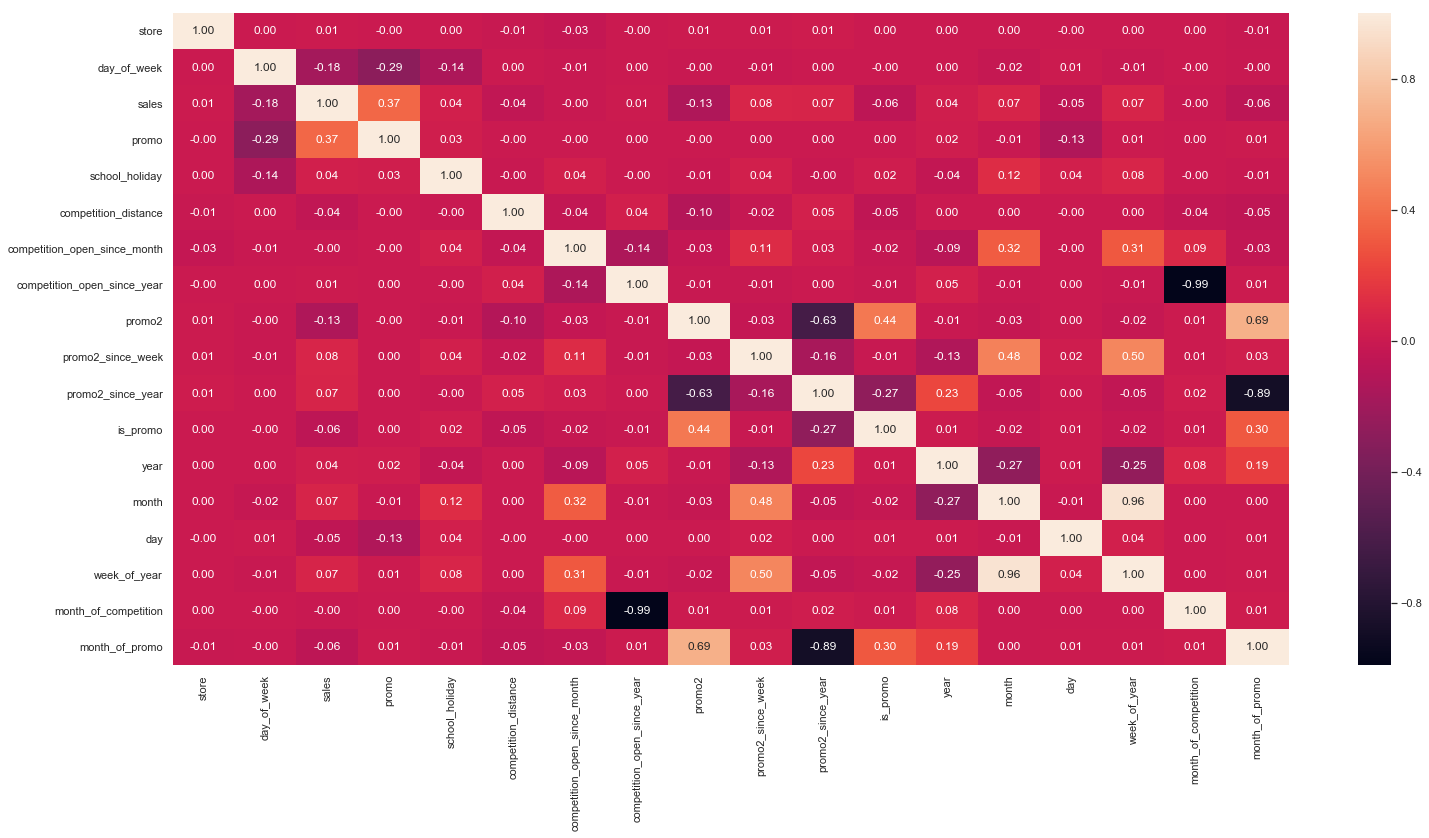

In [49]:
correlation = num_attributes.corr()
sns.heatmap( correlation, annot=True, fmt='.2f' )

plt.show()

# 6.0. DATA PREPARATION
---

In [50]:
df6 = df5.copy()

## 6.1. Numerical Predictors

### 6.1.1. Standardizing ( Normal Distribution )

### 6.1.2. Normalization ( Rescaling )

## 6.2. Categorical Predictors

### 6.2.1. Label Encoding

In [51]:
# Label Encoder
le = LabelEncoder()

# state holiday
df6['state_holiday'] = df6['state_holiday'].apply( lambda x: 1 if x == 'regular_day' else 0 )
df6 = df6.rename( columns={'state_holiday':'regular_day'})

# store_type
le.fit( df6['store_type'].drop_duplicates() )
df6['store_type'] = le.transform( df6['store_type'] )

# assortment
le.fit( df6['assortment'].drop_duplicates() )
df6['assortment'] = le.transform( df6['assortment'] )

In [52]:
df6.head()

,store,day_of_week,date,sales,promo,regular_day,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,month_of_competition,month_of_promo
0,1,5,2015-07-31,5263,1,1,1,2,0,1270.0,9,2008,0,31,2015,0,2015,7,31,31,82,0.00
1,2,5,2015-07-31,6064,1,1,1,0,0,570.0,11,2007,1,13,2010,1,2015,7,31,31,92,64.50
2,3,5,2015-07-31,8314,1,1,1,0,0,14130.0,12,2006,1,14,2011,1,2015,7,31,31,103,52.25
3,4,5,2015-07-31,13995,1,1,1,2,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,70,0.00
4,5,5,2015-07-31,4822,1,1,1,0,0,29910.0,4,2015,0,31,2015,0,2015,7,31,31,3,0.00


## 6.3. Response Variable

### 6.3.1. Transformations

# 7.0. FEATURE SELECTION
---

In [53]:
df7 = df6.copy()

## 7.1. Split training and test dataset

In [54]:
# split the last 6 weeks data as hold-out set
df7 = df7.sort_values( 'date', ascending=False )

## split training and test dataset
# training
X_train = df7[6*7*1115:]
y_train = np.log1p( X_train['sales'] )

# test
X_test = df7[:6*7*1115]
y_test = np.log1p( X_test['sales'] )

In [55]:
# Drop attributes
X_train = X_train.drop( ['sales', 'date'], axis=1 )
X_test = X_test.drop( ['sales', 'date'], axis=1 )

## 7.2. RFECV Selection ( Recursive Feature Elimination Cross Validation )

In [ ]:
# define the estimator
estimator = SVR( kernel='linear' )

# fit the RFE
rfecv = RFECV( estimator=estimator, cv=10, scoring='r2', n_jobs=-1 ).fit( X_train, y_train )

# select variables and calculate test accuracy
cols_selected = X_train.columns[ rfecv.support_ ]

## select the best features
#data = X_train[ cols_selected ]
#data['sales'] = y_train

## 7.3. Embedded Method

In [ ]:
# Linear Regression - Lasso CV Regularization
reg = LassoCV()

reg.fit( X_train, y_train )
print( 'Best alpha using built-in LassoCV: {}'.format( reg.alpha_ ) )
print( 'Best score using built-in LassoCV: {}'.format( reg.score( X_train, y_train ) ) )

coef = pd.Series( reg.coef_, index=X_train.columns )

cols_selected = list( coef[coef != 0].index )
print( 'Lasso picked ' + str( sum( coef != 0 ) ) + ' variables and eliminated the other ' + str( sum( coef == 0 ) ) + ' variables' )

# plot importances
imp_coef = coef.sort_values()
imp_coef.plot( kind='barh' )
plt.title( 'Feature importance using Lasso Model' );

# select the best features
#data = X_train [ cols_selected ]
#data['sales'] = y_train

## 7.4. Boruta Feature Selection

In [ ]:
X_train_n = X_train.values
X_train_n = y_train.values.ravel()

# define random forest regressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta features selection method
boruta = BorutaPy( rf, n_estimators='auto', verbose=0, random_state=1 ).fit( X_train_n, y_train_n )

# selecting features based on the chosen ranking
rank_list = [1]
cols_selected [ True if x in rank_list else False for x in boruta.ranking_ ]

# select the best features
data = X.iloc[:, cols_selected]
data['sales'] = y_train

## 7.5. Manual Feature Selection

# 8.0. MACHINE LEARNING MODELLING
---

In [56]:
def ml_error( model_name, y_test, yhat ):
    error = rmspe( y_test, yhat )
    mae = mean_absolute_error( y_test, yhat )
    rmse = np.sqrt( mean_squared_error( y_test, yhat ) )
    
    return pd.DataFrame( {'Model':model_name, 'RMSPE':error, 'RMSE':rmse, 'MAE':mae}, index=[0] )

## 8.1. Average Model ( Baseline Model )

In [59]:
# dataset
aux = X_test.copy()
aux['sales'] = y_test.copy()

# predictions
yhat_store = aux[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'} )
aux1 = pd.merge( aux, yhat_store, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance 
baseline_results = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
print( baseline_results )

           Model     RMSPE         RMSE          MAE
0  Average Model  0.726751  1878.694596  1400.295276


## 8.2. Linear Regression

In [60]:
# model
lr = LinearRegression().fit( X_train, y_train )

# predictions
yhat_lr = lr.predict( X_test )

# performance 
lr_results = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
print( lr_results )

               Model     RMSPE         RMSE          MAE
0  Linear Regression  0.439315  2719.583353  1928.658545


## 8.3. Linear Regression Regularized

In [61]:
# model
lrr = Lasso( alpha=0.01 ).fit( X_train, y_train )

# predictions
yhat_lrr = lrr.predict( X_test )

# performance 
lrr_results = ml_error( 'Linear Regression Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
print( lrr_results )

                     Model     RMSPE         RMSE          MAE
0  Linear Regression Lasso  0.426222  2771.655845  1931.954218


## 8.4. Random Forest Regressor

In [63]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=0 ).fit( X_train, y_train )

# predictions
yhat_rf = rf.predict( X_test )

# performance
rf_results = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
print( rf_results )

                     Model     RMSPE         RMSE         MAE
0  Random Forest Regressor  0.147634  1060.412205  715.613667


## 8.5. SVR ( Support Vector Regressor )

In [ ]:
# model
svr = SVR( kernel='rbf', C=1.0 ).fit( X_train, y_train )

# predictions
yhat_svr = svr.predict( X_test )

# performance
svr_results = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_svr ) )
print( svr_results )

## 8.5. XGBoost Regressor

### 8.5.1. Training

In [115]:
# parameters
params = { 
    'objective': 'reg:linear', 
    'booster': 'gbtree',
    'eta': 0.03,
    'max_depth': 10,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'silent': 1,
    'seed': 10 
         }
num_boost_round = 6000

# training
dtrain = xgb.DMatrix( X_train, y_train )
dvalid = xgb.DMatrix( X_test, y_test )
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

print( '===> start: XGBoost training')
start = time()
gbm = xgb.train( params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True )
end = time()
print( '===> end: XGBoost training')

===> start: XGBoost training
[0]	train-rmse:8.01965	eval-rmse:8.04735	train-rmspe:0.999808	eval-rmspe:0.999814
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.77954	eval-rmse:7.80696	train-rmspe:0.99971	eval-rmspe:0.999719
[2]	train-rmse:7.54663	eval-rmse:7.57418	train-rmspe:0.99959	eval-rmspe:0.999603
[3]	train-rmse:7.32071	eval-rmse:7.34826	train-rmspe:0.999443	eval-rmspe:0.999461
[4]	train-rmse:7.1016	eval-rmse:7.1289	train-rmspe:0.999266	eval-rmspe:0.999289
[5]	train-rmse:6.88908	eval-rmse:6.9157	train-rmspe:0.999053	eval-rmspe:0.999082
[6]	train-rmse:6.68302	eval-rmse:6.70944	train-rmspe:0.998798	eval-rmspe:0.998834
[7]	train-rmse:6.48304	eval-rmse:6.50928	train-rmspe:0.998496	eval-rmspe:0.998542
[8]	train-rmse:6.2891	eval-rmse:6.31518	train-rmspe:0.99814	eval-rmspe:0.998196
[9]	train-rmse:6.101	eval-rmse:6.12677	train-rmspe:0.997723	eval-rmspe:0.99779
[10]	train-rmse

[97]	train-rmse:0.490773	eval-rmse:0.491438	train-rmspe:0.379962	eval-rmspe:0.367915
[98]	train-rmse:0.479972	eval-rmse:0.479787	train-rmspe:0.37417	eval-rmspe:0.361054
[99]	train-rmse:0.469591	eval-rmse:0.469521	train-rmspe:0.3686	eval-rmspe:0.355034
[100]	train-rmse:0.45954	eval-rmse:0.459699	train-rmspe:0.363215	eval-rmspe:0.349284
[101]	train-rmse:0.449694	eval-rmse:0.449628	train-rmspe:0.357944	eval-rmspe:0.343391
[102]	train-rmse:0.440197	eval-rmse:0.440227	train-rmspe:0.352909	eval-rmspe:0.33789
[103]	train-rmse:0.431192	eval-rmse:0.43135	train-rmspe:0.348024	eval-rmspe:0.332684
[104]	train-rmse:0.422242	eval-rmse:0.422465	train-rmspe:0.343207	eval-rmspe:0.327437
[105]	train-rmse:0.413895	eval-rmse:0.414281	train-rmspe:0.338768	eval-rmspe:0.322625
[106]	train-rmse:0.405994	eval-rmse:0.406713	train-rmspe:0.334635	eval-rmspe:0.318182
[107]	train-rmse:0.398365	eval-rmse:0.399083	train-rmspe:0.330517	eval-rmspe:0.313742
[108]	train-rmse:0.391059	eval-rmse:0.391947	train-rmspe:0.3266

[193]	train-rmse:0.204274	eval-rmse:0.214209	train-rmspe:0.246881	eval-rmspe:0.224648
[194]	train-rmse:0.204138	eval-rmse:0.214123	train-rmspe:0.246959	eval-rmspe:0.224773
[195]	train-rmse:0.202917	eval-rmse:0.212881	train-rmspe:0.246004	eval-rmspe:0.223658
[196]	train-rmse:0.202477	eval-rmse:0.212438	train-rmspe:0.245844	eval-rmspe:0.223412
[197]	train-rmse:0.202215	eval-rmse:0.212314	train-rmspe:0.245722	eval-rmspe:0.223522
[198]	train-rmse:0.201863	eval-rmse:0.212022	train-rmspe:0.24561	eval-rmspe:0.22345
[199]	train-rmse:0.201622	eval-rmse:0.211804	train-rmspe:0.245579	eval-rmspe:0.223457
[200]	train-rmse:0.201041	eval-rmse:0.211278	train-rmspe:0.245266	eval-rmspe:0.222996
[201]	train-rmse:0.200528	eval-rmse:0.210822	train-rmspe:0.245039	eval-rmspe:0.222654
[202]	train-rmse:0.199999	eval-rmse:0.210336	train-rmspe:0.244762	eval-rmspe:0.22233
[203]	train-rmse:0.199835	eval-rmse:0.210216	train-rmspe:0.244805	eval-rmspe:0.222404
[204]	train-rmse:0.199482	eval-rmse:0.209895	train-rmspe:

[289]	train-rmse:0.169441	eval-rmse:0.183525	train-rmspe:0.218839	eval-rmspe:0.197074
[290]	train-rmse:0.168882	eval-rmse:0.183067	train-rmspe:0.218317	eval-rmspe:0.1965
[291]	train-rmse:0.16862	eval-rmse:0.182833	train-rmspe:0.218083	eval-rmspe:0.196245
[292]	train-rmse:0.168513	eval-rmse:0.182752	train-rmspe:0.217988	eval-rmspe:0.196162
[293]	train-rmse:0.168303	eval-rmse:0.182588	train-rmspe:0.217807	eval-rmspe:0.195966
[294]	train-rmse:0.168028	eval-rmse:0.182337	train-rmspe:0.217594	eval-rmspe:0.195721
[295]	train-rmse:0.167962	eval-rmse:0.182281	train-rmspe:0.217552	eval-rmspe:0.195666
[296]	train-rmse:0.167922	eval-rmse:0.182258	train-rmspe:0.217432	eval-rmspe:0.195652
[297]	train-rmse:0.167662	eval-rmse:0.182051	train-rmspe:0.217205	eval-rmspe:0.195447
[298]	train-rmse:0.167391	eval-rmse:0.181817	train-rmspe:0.216827	eval-rmspe:0.195216
[299]	train-rmse:0.166715	eval-rmse:0.181234	train-rmspe:0.216254	eval-rmspe:0.194651
[300]	train-rmse:0.166575	eval-rmse:0.181221	train-rmspe:

[385]	train-rmse:0.144376	eval-rmse:0.162121	train-rmspe:0.18858	eval-rmspe:0.1738
[386]	train-rmse:0.144084	eval-rmse:0.161869	train-rmspe:0.1883	eval-rmspe:0.173498
[387]	train-rmse:0.143905	eval-rmse:0.16169	train-rmspe:0.188143	eval-rmspe:0.173321
[388]	train-rmse:0.143751	eval-rmse:0.161546	train-rmspe:0.188008	eval-rmspe:0.173167
[389]	train-rmse:0.143613	eval-rmse:0.161428	train-rmspe:0.187878	eval-rmspe:0.173047
[390]	train-rmse:0.143559	eval-rmse:0.16139	train-rmspe:0.187826	eval-rmspe:0.172993
[391]	train-rmse:0.143408	eval-rmse:0.161254	train-rmspe:0.1877	eval-rmspe:0.172852
[392]	train-rmse:0.143076	eval-rmse:0.160949	train-rmspe:0.187362	eval-rmspe:0.172509
[393]	train-rmse:0.142788	eval-rmse:0.160692	train-rmspe:0.1871	eval-rmspe:0.172233
[394]	train-rmse:0.142699	eval-rmse:0.160609	train-rmspe:0.187001	eval-rmspe:0.172159
[395]	train-rmse:0.142451	eval-rmse:0.160378	train-rmspe:0.186723	eval-rmspe:0.171884
[396]	train-rmse:0.142298	eval-rmse:0.160222	train-rmspe:0.186593

[481]	train-rmse:0.128704	eval-rmse:0.148927	train-rmspe:0.167786	eval-rmspe:0.159113
[482]	train-rmse:0.128673	eval-rmse:0.148902	train-rmspe:0.167728	eval-rmspe:0.159091
[483]	train-rmse:0.128525	eval-rmse:0.148778	train-rmspe:0.167598	eval-rmspe:0.158946
[484]	train-rmse:0.128498	eval-rmse:0.148757	train-rmspe:0.167589	eval-rmspe:0.158923
[485]	train-rmse:0.128368	eval-rmse:0.148656	train-rmspe:0.167473	eval-rmspe:0.158824
[486]	train-rmse:0.128303	eval-rmse:0.148613	train-rmspe:0.167405	eval-rmspe:0.158748
[487]	train-rmse:0.128201	eval-rmse:0.148516	train-rmspe:0.167312	eval-rmspe:0.158634
[488]	train-rmse:0.128095	eval-rmse:0.148427	train-rmspe:0.167222	eval-rmspe:0.15854
[489]	train-rmse:0.127972	eval-rmse:0.148322	train-rmspe:0.167102	eval-rmspe:0.158437
[490]	train-rmse:0.12793	eval-rmse:0.148294	train-rmspe:0.167075	eval-rmspe:0.158407
[491]	train-rmse:0.127689	eval-rmse:0.148101	train-rmspe:0.166871	eval-rmspe:0.158214
[492]	train-rmse:0.127534	eval-rmse:0.147962	train-rmspe

[577]	train-rmse:0.116588	eval-rmse:0.138908	train-rmspe:0.154112	eval-rmspe:0.147375
[578]	train-rmse:0.116391	eval-rmse:0.138745	train-rmspe:0.153867	eval-rmspe:0.147191
[579]	train-rmse:0.116291	eval-rmse:0.138666	train-rmspe:0.153778	eval-rmspe:0.147111
[580]	train-rmse:0.116184	eval-rmse:0.138579	train-rmspe:0.15367	eval-rmspe:0.147017
[581]	train-rmse:0.116123	eval-rmse:0.138556	train-rmspe:0.153263	eval-rmspe:0.146988
[582]	train-rmse:0.116079	eval-rmse:0.138514	train-rmspe:0.153228	eval-rmspe:0.146943
[583]	train-rmse:0.115964	eval-rmse:0.138419	train-rmspe:0.153097	eval-rmspe:0.146837
[584]	train-rmse:0.115853	eval-rmse:0.13834	train-rmspe:0.152993	eval-rmspe:0.146744
[585]	train-rmse:0.115771	eval-rmse:0.138273	train-rmspe:0.152923	eval-rmspe:0.146669
[586]	train-rmse:0.115642	eval-rmse:0.13812	train-rmspe:0.152487	eval-rmspe:0.146497
[587]	train-rmse:0.11561	eval-rmse:0.138088	train-rmspe:0.152441	eval-rmspe:0.146461
[588]	train-rmse:0.115535	eval-rmse:0.138019	train-rmspe:0

[673]	train-rmse:0.108394	eval-rmse:0.132249	train-rmspe:0.141304	eval-rmspe:0.140033
[674]	train-rmse:0.108346	eval-rmse:0.132203	train-rmspe:0.141249	eval-rmspe:0.139991
[675]	train-rmse:0.108321	eval-rmse:0.132185	train-rmspe:0.141223	eval-rmspe:0.139973
[676]	train-rmse:0.108243	eval-rmse:0.132129	train-rmspe:0.141156	eval-rmspe:0.139913
[677]	train-rmse:0.10822	eval-rmse:0.132112	train-rmspe:0.140911	eval-rmspe:0.139896
[678]	train-rmse:0.10816	eval-rmse:0.132061	train-rmspe:0.140858	eval-rmspe:0.139839
[679]	train-rmse:0.108102	eval-rmse:0.132012	train-rmspe:0.140801	eval-rmspe:0.139791
[680]	train-rmse:0.108041	eval-rmse:0.131966	train-rmspe:0.140753	eval-rmspe:0.139741
[681]	train-rmse:0.107987	eval-rmse:0.131931	train-rmspe:0.140716	eval-rmspe:0.139707
[682]	train-rmse:0.10792	eval-rmse:0.13189	train-rmspe:0.140648	eval-rmspe:0.139669
[683]	train-rmse:0.107785	eval-rmse:0.131779	train-rmspe:0.140515	eval-rmspe:0.139543
[684]	train-rmse:0.107772	eval-rmse:0.131771	train-rmspe:0

[769]	train-rmse:0.102917	eval-rmse:0.12826	train-rmspe:0.133488	eval-rmspe:0.135821
[770]	train-rmse:0.102867	eval-rmse:0.128227	train-rmspe:0.133451	eval-rmspe:0.135787
[771]	train-rmse:0.102768	eval-rmse:0.128154	train-rmspe:0.133367	eval-rmspe:0.135711
[772]	train-rmse:0.102701	eval-rmse:0.128104	train-rmspe:0.133308	eval-rmspe:0.135666
[773]	train-rmse:0.102659	eval-rmse:0.128111	train-rmspe:0.133227	eval-rmspe:0.135684
[774]	train-rmse:0.102601	eval-rmse:0.128081	train-rmspe:0.133174	eval-rmspe:0.135652
[775]	train-rmse:0.10259	eval-rmse:0.128076	train-rmspe:0.133164	eval-rmspe:0.135651
[776]	train-rmse:0.10252	eval-rmse:0.128031	train-rmspe:0.133102	eval-rmspe:0.135616
[777]	train-rmse:0.102464	eval-rmse:0.128056	train-rmspe:0.133037	eval-rmspe:0.135665
[778]	train-rmse:0.102384	eval-rmse:0.127968	train-rmspe:0.132914	eval-rmspe:0.135555
[779]	train-rmse:0.102333	eval-rmse:0.127958	train-rmspe:0.132862	eval-rmspe:0.135521
[780]	train-rmse:0.102271	eval-rmse:0.127918	train-rmspe:

[865]	train-rmse:0.098568	eval-rmse:0.125063	train-rmspe:0.128587	eval-rmspe:0.13227
[866]	train-rmse:0.098522	eval-rmse:0.125024	train-rmspe:0.128541	eval-rmspe:0.132226
[867]	train-rmse:0.098479	eval-rmse:0.12501	train-rmspe:0.128492	eval-rmspe:0.132219
[868]	train-rmse:0.098435	eval-rmse:0.124992	train-rmspe:0.128455	eval-rmspe:0.1322
[869]	train-rmse:0.098392	eval-rmse:0.125075	train-rmspe:0.128415	eval-rmspe:0.132295
[870]	train-rmse:0.098377	eval-rmse:0.125055	train-rmspe:0.128402	eval-rmspe:0.132278
[871]	train-rmse:0.098324	eval-rmse:0.125028	train-rmspe:0.128333	eval-rmspe:0.132237
[872]	train-rmse:0.098298	eval-rmse:0.125018	train-rmspe:0.128303	eval-rmspe:0.132228
[873]	train-rmse:0.098272	eval-rmse:0.125002	train-rmspe:0.12827	eval-rmspe:0.132212
[874]	train-rmse:0.098237	eval-rmse:0.124977	train-rmspe:0.128239	eval-rmspe:0.132186
[875]	train-rmse:0.098205	eval-rmse:0.124958	train-rmspe:0.128211	eval-rmspe:0.132161
[876]	train-rmse:0.098151	eval-rmse:0.12493	train-rmspe:0.1

[961]	train-rmse:0.095	eval-rmse:0.123108	train-rmspe:0.124088	eval-rmspe:0.130129
[962]	train-rmse:0.094956	eval-rmse:0.123148	train-rmspe:0.12405	eval-rmspe:0.130163
[963]	train-rmse:0.094912	eval-rmse:0.12312	train-rmspe:0.124003	eval-rmspe:0.130134
[964]	train-rmse:0.094907	eval-rmse:0.123116	train-rmspe:0.123999	eval-rmspe:0.13013
[965]	train-rmse:0.094861	eval-rmse:0.123088	train-rmspe:0.123347	eval-rmspe:0.130104
[966]	train-rmse:0.094825	eval-rmse:0.123062	train-rmspe:0.123311	eval-rmspe:0.130076
[967]	train-rmse:0.09482	eval-rmse:0.123061	train-rmspe:0.123305	eval-rmspe:0.130076
[968]	train-rmse:0.094794	eval-rmse:0.123052	train-rmspe:0.123283	eval-rmspe:0.130061
[969]	train-rmse:0.094738	eval-rmse:0.12301	train-rmspe:0.123233	eval-rmspe:0.130022
[970]	train-rmse:0.094711	eval-rmse:0.122993	train-rmspe:0.123208	eval-rmspe:0.130004
[971]	train-rmse:0.094703	eval-rmse:0.122989	train-rmspe:0.1232	eval-rmspe:0.129999
[972]	train-rmse:0.094679	eval-rmse:0.122976	train-rmspe:0.12316

[1057]	train-rmse:0.092107	eval-rmse:0.121385	train-rmspe:0.119397	eval-rmspe:0.128262
[1058]	train-rmse:0.092075	eval-rmse:0.121361	train-rmspe:0.119358	eval-rmspe:0.128235
[1059]	train-rmse:0.092044	eval-rmse:0.121343	train-rmspe:0.119323	eval-rmspe:0.128217
[1060]	train-rmse:0.092015	eval-rmse:0.121337	train-rmspe:0.119291	eval-rmspe:0.128179
[1061]	train-rmse:0.091992	eval-rmse:0.121331	train-rmspe:0.119273	eval-rmspe:0.128174
[1062]	train-rmse:0.091983	eval-rmse:0.121323	train-rmspe:0.119264	eval-rmspe:0.128166
[1063]	train-rmse:0.091968	eval-rmse:0.121353	train-rmspe:0.119236	eval-rmspe:0.128133
[1064]	train-rmse:0.091934	eval-rmse:0.121326	train-rmspe:0.119164	eval-rmspe:0.128097
[1065]	train-rmse:0.091897	eval-rmse:0.121295	train-rmspe:0.119115	eval-rmspe:0.128057
[1066]	train-rmse:0.091867	eval-rmse:0.12129	train-rmspe:0.119058	eval-rmspe:0.128053
[1067]	train-rmse:0.091841	eval-rmse:0.121273	train-rmspe:0.119035	eval-rmspe:0.128039
[1068]	train-rmse:0.091813	eval-rmse:0.12125

[1152]	train-rmse:0.089728	eval-rmse:0.120341	train-rmspe:0.115023	eval-rmspe:0.127087
[1153]	train-rmse:0.089703	eval-rmse:0.120324	train-rmspe:0.114987	eval-rmspe:0.12707
[1154]	train-rmse:0.089674	eval-rmse:0.12031	train-rmspe:0.11496	eval-rmspe:0.127056
[1155]	train-rmse:0.089658	eval-rmse:0.120295	train-rmspe:0.114947	eval-rmspe:0.127039
[1156]	train-rmse:0.089642	eval-rmse:0.120291	train-rmspe:0.114932	eval-rmspe:0.127028
[1157]	train-rmse:0.089613	eval-rmse:0.12028	train-rmspe:0.114902	eval-rmspe:0.127017
[1158]	train-rmse:0.089582	eval-rmse:0.120281	train-rmspe:0.114832	eval-rmspe:0.12702
[1159]	train-rmse:0.089528	eval-rmse:0.120243	train-rmspe:0.114791	eval-rmspe:0.126978
[1160]	train-rmse:0.089495	eval-rmse:0.120225	train-rmspe:0.114741	eval-rmspe:0.126962
[1161]	train-rmse:0.089459	eval-rmse:0.120197	train-rmspe:0.114682	eval-rmspe:0.126891
[1162]	train-rmse:0.089451	eval-rmse:0.120192	train-rmspe:0.114674	eval-rmspe:0.126887
[1163]	train-rmse:0.089428	eval-rmse:0.120181	tr

[1247]	train-rmse:0.08753	eval-rmse:0.11946	train-rmspe:0.110957	eval-rmspe:0.126172
[1248]	train-rmse:0.087516	eval-rmse:0.119447	train-rmspe:0.110943	eval-rmspe:0.126154
[1249]	train-rmse:0.08749	eval-rmse:0.119438	train-rmspe:0.110907	eval-rmspe:0.126144
[1250]	train-rmse:0.087474	eval-rmse:0.119427	train-rmspe:0.110892	eval-rmspe:0.126133
[1251]	train-rmse:0.087455	eval-rmse:0.119435	train-rmspe:0.110875	eval-rmspe:0.126139
[1252]	train-rmse:0.087431	eval-rmse:0.119431	train-rmspe:0.110836	eval-rmspe:0.126139
[1253]	train-rmse:0.087395	eval-rmse:0.119408	train-rmspe:0.110805	eval-rmspe:0.126115
[1254]	train-rmse:0.087366	eval-rmse:0.119402	train-rmspe:0.11078	eval-rmspe:0.126101
[1255]	train-rmse:0.08734	eval-rmse:0.119391	train-rmspe:0.110745	eval-rmspe:0.126093
[1256]	train-rmse:0.087321	eval-rmse:0.119385	train-rmspe:0.110728	eval-rmspe:0.126088
[1257]	train-rmse:0.087303	eval-rmse:0.119372	train-rmspe:0.110714	eval-rmspe:0.126076
[1258]	train-rmse:0.087283	eval-rmse:0.119362	tr

[1342]	train-rmse:0.085754	eval-rmse:0.118784	train-rmspe:0.108495	eval-rmspe:0.125352
[1343]	train-rmse:0.085737	eval-rmse:0.118776	train-rmspe:0.108478	eval-rmspe:0.125364
[1344]	train-rmse:0.085716	eval-rmse:0.11877	train-rmspe:0.10846	eval-rmspe:0.125358
[1345]	train-rmse:0.085697	eval-rmse:0.11876	train-rmspe:0.108428	eval-rmspe:0.125346
[1346]	train-rmse:0.085673	eval-rmse:0.118746	train-rmspe:0.1084	eval-rmspe:0.125331
[1347]	train-rmse:0.085659	eval-rmse:0.118742	train-rmspe:0.108312	eval-rmspe:0.125325
[1348]	train-rmse:0.085643	eval-rmse:0.118741	train-rmspe:0.108289	eval-rmspe:0.125323
[1349]	train-rmse:0.085621	eval-rmse:0.118729	train-rmspe:0.10827	eval-rmspe:0.125311
[1350]	train-rmse:0.085596	eval-rmse:0.11871	train-rmspe:0.108249	eval-rmspe:0.125292
[1351]	train-rmse:0.085577	eval-rmse:0.118703	train-rmspe:0.108224	eval-rmspe:0.125284
[1352]	train-rmse:0.085556	eval-rmse:0.118693	train-rmspe:0.108204	eval-rmspe:0.125274
[1353]	train-rmse:0.085545	eval-rmse:0.118693	trai

[1437]	train-rmse:0.084035	eval-rmse:0.118285	train-rmspe:0.105921	eval-rmspe:0.124871
[1438]	train-rmse:0.084025	eval-rmse:0.118286	train-rmspe:0.105912	eval-rmspe:0.124872
[1439]	train-rmse:0.08401	eval-rmse:0.118284	train-rmspe:0.105898	eval-rmspe:0.124869
[1440]	train-rmse:0.084	eval-rmse:0.118284	train-rmspe:0.105889	eval-rmspe:0.12487
[1441]	train-rmse:0.083983	eval-rmse:0.118282	train-rmspe:0.105872	eval-rmspe:0.124873
[1442]	train-rmse:0.08397	eval-rmse:0.118278	train-rmspe:0.105841	eval-rmspe:0.124868
[1443]	train-rmse:0.083951	eval-rmse:0.118233	train-rmspe:0.105823	eval-rmspe:0.124811
[1444]	train-rmse:0.083941	eval-rmse:0.118229	train-rmspe:0.105828	eval-rmspe:0.124807
[1445]	train-rmse:0.083911	eval-rmse:0.118211	train-rmspe:0.105801	eval-rmspe:0.124788
[1446]	train-rmse:0.083874	eval-rmse:0.118191	train-rmspe:0.105765	eval-rmspe:0.124766
[1447]	train-rmse:0.083858	eval-rmse:0.118186	train-rmspe:0.105743	eval-rmspe:0.124758
[1448]	train-rmse:0.083841	eval-rmse:0.118183	tra

[1532]	train-rmse:0.082559	eval-rmse:0.117887	train-rmspe:0.103586	eval-rmspe:0.124445
[1533]	train-rmse:0.082543	eval-rmse:0.11788	train-rmspe:0.103563	eval-rmspe:0.124438
[1534]	train-rmse:0.08253	eval-rmse:0.117875	train-rmspe:0.103523	eval-rmspe:0.124434
[1535]	train-rmse:0.082505	eval-rmse:0.117863	train-rmspe:0.103478	eval-rmspe:0.12442
[1536]	train-rmse:0.08249	eval-rmse:0.117856	train-rmspe:0.103459	eval-rmspe:0.12441
[1537]	train-rmse:0.082468	eval-rmse:0.117841	train-rmspe:0.103396	eval-rmspe:0.124397
[1538]	train-rmse:0.082459	eval-rmse:0.117833	train-rmspe:0.103389	eval-rmspe:0.12439
[1539]	train-rmse:0.082453	eval-rmse:0.117831	train-rmspe:0.103384	eval-rmspe:0.124388
[1540]	train-rmse:0.082438	eval-rmse:0.117818	train-rmspe:0.103299	eval-rmspe:0.124374
[1541]	train-rmse:0.082419	eval-rmse:0.117816	train-rmspe:0.103283	eval-rmspe:0.12437
[1542]	train-rmse:0.082409	eval-rmse:0.117812	train-rmspe:0.103268	eval-rmspe:0.124366
[1543]	train-rmse:0.082389	eval-rmse:0.117803	trai

[1627]	train-rmse:0.081166	eval-rmse:0.11753	train-rmspe:0.101486	eval-rmspe:0.124033
[1628]	train-rmse:0.081164	eval-rmse:0.11753	train-rmspe:0.101484	eval-rmspe:0.124032
[1629]	train-rmse:0.081161	eval-rmse:0.117529	train-rmspe:0.101484	eval-rmspe:0.124032
[1630]	train-rmse:0.081145	eval-rmse:0.117524	train-rmspe:0.101467	eval-rmspe:0.124028
[1631]	train-rmse:0.081131	eval-rmse:0.117522	train-rmspe:0.101452	eval-rmspe:0.124026
[1632]	train-rmse:0.081105	eval-rmse:0.117514	train-rmspe:0.101428	eval-rmspe:0.124017
[1633]	train-rmse:0.081085	eval-rmse:0.117506	train-rmspe:0.101389	eval-rmspe:0.12401
[1634]	train-rmse:0.081073	eval-rmse:0.117506	train-rmspe:0.101375	eval-rmspe:0.124011
[1635]	train-rmse:0.081059	eval-rmse:0.117499	train-rmspe:0.10136	eval-rmspe:0.124006
[1636]	train-rmse:0.081046	eval-rmse:0.117494	train-rmspe:0.10135	eval-rmspe:0.124002
[1637]	train-rmse:0.081029	eval-rmse:0.117486	train-rmspe:0.101331	eval-rmspe:0.123992
[1638]	train-rmse:0.08102	eval-rmse:0.117486	tra

[1722]	train-rmse:0.079955	eval-rmse:0.117234	train-rmspe:0.099074	eval-rmspe:0.123668
[1723]	train-rmse:0.079938	eval-rmse:0.117228	train-rmspe:0.099054	eval-rmspe:0.123662
[1724]	train-rmse:0.079929	eval-rmse:0.117227	train-rmspe:0.099046	eval-rmspe:0.123659
[1725]	train-rmse:0.079911	eval-rmse:0.117226	train-rmspe:0.099018	eval-rmspe:0.123663
[1726]	train-rmse:0.079905	eval-rmse:0.117224	train-rmspe:0.098707	eval-rmspe:0.12366
[1727]	train-rmse:0.079899	eval-rmse:0.117222	train-rmspe:0.098702	eval-rmspe:0.123657
[1728]	train-rmse:0.079887	eval-rmse:0.117218	train-rmspe:0.09869	eval-rmspe:0.123652
[1729]	train-rmse:0.079866	eval-rmse:0.117226	train-rmspe:0.098658	eval-rmspe:0.123654
[1730]	train-rmse:0.079848	eval-rmse:0.117219	train-rmspe:0.098635	eval-rmspe:0.123647
[1731]	train-rmse:0.079831	eval-rmse:0.117214	train-rmspe:0.098613	eval-rmspe:0.123642
[1732]	train-rmse:0.079818	eval-rmse:0.117211	train-rmspe:0.098567	eval-rmspe:0.123639
[1733]	train-rmse:0.079806	eval-rmse:0.117209

[1817]	train-rmse:0.078751	eval-rmse:0.117067	train-rmspe:0.095476	eval-rmspe:0.12349
[1818]	train-rmse:0.078746	eval-rmse:0.117065	train-rmspe:0.09547	eval-rmspe:0.123487
[1819]	train-rmse:0.078733	eval-rmse:0.11706	train-rmspe:0.095454	eval-rmspe:0.123483
[1820]	train-rmse:0.078721	eval-rmse:0.117058	train-rmspe:0.09544	eval-rmspe:0.123481
[1821]	train-rmse:0.078708	eval-rmse:0.117057	train-rmspe:0.095425	eval-rmspe:0.123479
[1822]	train-rmse:0.078696	eval-rmse:0.117055	train-rmspe:0.095408	eval-rmspe:0.123476
[1823]	train-rmse:0.078686	eval-rmse:0.117051	train-rmspe:0.095398	eval-rmspe:0.123472
[1824]	train-rmse:0.078673	eval-rmse:0.117066	train-rmspe:0.09537	eval-rmspe:0.123478
[1825]	train-rmse:0.078664	eval-rmse:0.117061	train-rmspe:0.095361	eval-rmspe:0.123472
[1826]	train-rmse:0.078651	eval-rmse:0.117059	train-rmspe:0.095348	eval-rmspe:0.123469
[1827]	train-rmse:0.078648	eval-rmse:0.117059	train-rmspe:0.095345	eval-rmspe:0.123471
[1828]	train-rmse:0.078635	eval-rmse:0.117055	tr

[1912]	train-rmse:0.077714	eval-rmse:0.116884	train-rmspe:0.092895	eval-rmspe:0.123234
[1913]	train-rmse:0.077705	eval-rmse:0.11688	train-rmspe:0.092886	eval-rmspe:0.12323
[1914]	train-rmse:0.077694	eval-rmse:0.11688	train-rmspe:0.092876	eval-rmspe:0.123225
[1915]	train-rmse:0.077688	eval-rmse:0.116876	train-rmspe:0.09287	eval-rmspe:0.123223
[1916]	train-rmse:0.077678	eval-rmse:0.116871	train-rmspe:0.092883	eval-rmspe:0.123218
[1917]	train-rmse:0.077675	eval-rmse:0.116872	train-rmspe:0.09288	eval-rmspe:0.123219
[1918]	train-rmse:0.077658	eval-rmse:0.116861	train-rmspe:0.09283	eval-rmspe:0.123199
[1919]	train-rmse:0.077639	eval-rmse:0.116854	train-rmspe:0.092812	eval-rmspe:0.123192
[1920]	train-rmse:0.077629	eval-rmse:0.11685	train-rmspe:0.092801	eval-rmspe:0.123187
[1921]	train-rmse:0.077619	eval-rmse:0.116849	train-rmspe:0.092786	eval-rmspe:0.123187
[1922]	train-rmse:0.077608	eval-rmse:0.116855	train-rmspe:0.092775	eval-rmspe:0.123195
[1923]	train-rmse:0.077604	eval-rmse:0.116852	trai

[2007]	train-rmse:0.0766	eval-rmse:0.11672	train-rmspe:0.088792	eval-rmspe:0.123023
[2008]	train-rmse:0.076588	eval-rmse:0.11671	train-rmspe:0.088725	eval-rmspe:0.123012
[2009]	train-rmse:0.07657	eval-rmse:0.116701	train-rmspe:0.088705	eval-rmspe:0.123005
[2010]	train-rmse:0.076554	eval-rmse:0.116696	train-rmspe:0.088687	eval-rmspe:0.123
[2011]	train-rmse:0.076545	eval-rmse:0.116694	train-rmspe:0.088679	eval-rmspe:0.122998
[2012]	train-rmse:0.076532	eval-rmse:0.11669	train-rmspe:0.088664	eval-rmspe:0.122995
[2013]	train-rmse:0.076525	eval-rmse:0.116688	train-rmspe:0.088656	eval-rmspe:0.122995
[2014]	train-rmse:0.076511	eval-rmse:0.116684	train-rmspe:0.088643	eval-rmspe:0.122992
[2015]	train-rmse:0.076504	eval-rmse:0.116686	train-rmspe:0.088621	eval-rmspe:0.122998
[2016]	train-rmse:0.076497	eval-rmse:0.116686	train-rmspe:0.088611	eval-rmspe:0.122999
[2017]	train-rmse:0.07649	eval-rmse:0.116686	train-rmspe:0.088604	eval-rmspe:0.122998
[2018]	train-rmse:0.076483	eval-rmse:0.116684	train-r

[2102]	train-rmse:0.075613	eval-rmse:0.116589	train-rmspe:0.086267	eval-rmspe:0.122949
[2103]	train-rmse:0.075604	eval-rmse:0.116587	train-rmspe:0.086259	eval-rmspe:0.122946
[2104]	train-rmse:0.075596	eval-rmse:0.116585	train-rmspe:0.086251	eval-rmspe:0.122945
[2105]	train-rmse:0.075584	eval-rmse:0.116572	train-rmspe:0.086113	eval-rmspe:0.122927
[2106]	train-rmse:0.075564	eval-rmse:0.116568	train-rmspe:0.086091	eval-rmspe:0.122923
[2107]	train-rmse:0.075553	eval-rmse:0.116569	train-rmspe:0.086078	eval-rmspe:0.122923
[2108]	train-rmse:0.075546	eval-rmse:0.116568	train-rmspe:0.08607	eval-rmspe:0.122923
[2109]	train-rmse:0.075527	eval-rmse:0.116565	train-rmspe:0.086047	eval-rmspe:0.122921
[2110]	train-rmse:0.075517	eval-rmse:0.116562	train-rmspe:0.086026	eval-rmspe:0.12292
[2111]	train-rmse:0.075505	eval-rmse:0.116562	train-rmspe:0.086014	eval-rmspe:0.122923
[2112]	train-rmse:0.075497	eval-rmse:0.116558	train-rmspe:0.085982	eval-rmspe:0.122919
[2113]	train-rmse:0.075488	eval-rmse:0.116555

[2197]	train-rmse:0.07471	eval-rmse:0.116462	train-rmspe:0.084387	eval-rmspe:0.12277
[2198]	train-rmse:0.0747	eval-rmse:0.116464	train-rmspe:0.084375	eval-rmspe:0.122771
[2199]	train-rmse:0.074694	eval-rmse:0.116464	train-rmspe:0.084369	eval-rmspe:0.122773
[2200]	train-rmse:0.074681	eval-rmse:0.116462	train-rmspe:0.084356	eval-rmspe:0.122767
[2201]	train-rmse:0.074672	eval-rmse:0.116473	train-rmspe:0.084346	eval-rmspe:0.122778
[2202]	train-rmse:0.07466	eval-rmse:0.116472	train-rmspe:0.084329	eval-rmspe:0.122777
[2203]	train-rmse:0.074648	eval-rmse:0.116471	train-rmspe:0.084156	eval-rmspe:0.122775
[2204]	train-rmse:0.074637	eval-rmse:0.11647	train-rmspe:0.084144	eval-rmspe:0.122774
[2205]	train-rmse:0.074629	eval-rmse:0.116467	train-rmspe:0.08413	eval-rmspe:0.122772
[2206]	train-rmse:0.07461	eval-rmse:0.116462	train-rmspe:0.084109	eval-rmspe:0.122767
[2207]	train-rmse:0.074594	eval-rmse:0.116454	train-rmspe:0.084085	eval-rmspe:0.12276
[2208]	train-rmse:0.074578	eval-rmse:0.116449	train-

[2292]	train-rmse:0.073759	eval-rmse:0.116412	train-rmspe:0.081884	eval-rmspe:0.122705
[2293]	train-rmse:0.073754	eval-rmse:0.11641	train-rmspe:0.081879	eval-rmspe:0.122703
[2294]	train-rmse:0.073739	eval-rmse:0.116408	train-rmspe:0.081881	eval-rmspe:0.122701
[2295]	train-rmse:0.073732	eval-rmse:0.116408	train-rmspe:0.081873	eval-rmspe:0.122702
[2296]	train-rmse:0.073715	eval-rmse:0.116403	train-rmspe:0.081853	eval-rmspe:0.122698
[2297]	train-rmse:0.073706	eval-rmse:0.116399	train-rmspe:0.081844	eval-rmspe:0.122693
[2298]	train-rmse:0.073696	eval-rmse:0.116402	train-rmspe:0.081791	eval-rmspe:0.122699
[2299]	train-rmse:0.073688	eval-rmse:0.116399	train-rmspe:0.081771	eval-rmspe:0.122697
[2300]	train-rmse:0.073677	eval-rmse:0.116396	train-rmspe:0.081754	eval-rmspe:0.122695
[2301]	train-rmse:0.073668	eval-rmse:0.116395	train-rmspe:0.081687	eval-rmspe:0.122694
[2302]	train-rmse:0.07366	eval-rmse:0.116391	train-rmspe:0.081677	eval-rmspe:0.122689
[2303]	train-rmse:0.073649	eval-rmse:0.116395

[2387]	train-rmse:0.072938	eval-rmse:0.116372	train-rmspe:0.08055	eval-rmspe:0.122699
[2388]	train-rmse:0.072928	eval-rmse:0.116369	train-rmspe:0.080561	eval-rmspe:0.122694
[2389]	train-rmse:0.07292	eval-rmse:0.116366	train-rmspe:0.08055	eval-rmspe:0.122693
[2390]	train-rmse:0.07291	eval-rmse:0.116366	train-rmspe:0.080523	eval-rmspe:0.122692
[2391]	train-rmse:0.072899	eval-rmse:0.116364	train-rmspe:0.080505	eval-rmspe:0.122689
[2392]	train-rmse:0.072888	eval-rmse:0.116366	train-rmspe:0.080492	eval-rmspe:0.122688
[2393]	train-rmse:0.072882	eval-rmse:0.116364	train-rmspe:0.080485	eval-rmspe:0.122684
[2394]	train-rmse:0.072873	eval-rmse:0.116348	train-rmspe:0.080464	eval-rmspe:0.122658
[2395]	train-rmse:0.072862	eval-rmse:0.116342	train-rmspe:0.080451	eval-rmspe:0.122649
[2396]	train-rmse:0.072856	eval-rmse:0.116338	train-rmspe:0.080462	eval-rmspe:0.122646
[2397]	train-rmse:0.072844	eval-rmse:0.116336	train-rmspe:0.080444	eval-rmspe:0.122643
[2398]	train-rmse:0.072837	eval-rmse:0.116335	t

[2482]	train-rmse:0.072133	eval-rmse:0.116373	train-rmspe:0.079316	eval-rmspe:0.122647
[2483]	train-rmse:0.072123	eval-rmse:0.116373	train-rmspe:0.079305	eval-rmspe:0.122646
[2484]	train-rmse:0.072113	eval-rmse:0.116375	train-rmspe:0.079294	eval-rmspe:0.122648
[2485]	train-rmse:0.072106	eval-rmse:0.116375	train-rmspe:0.079285	eval-rmspe:0.12265
[2486]	train-rmse:0.072094	eval-rmse:0.116371	train-rmspe:0.079273	eval-rmspe:0.122645
[2487]	train-rmse:0.072083	eval-rmse:0.116368	train-rmspe:0.07926	eval-rmspe:0.122644
[2488]	train-rmse:0.072076	eval-rmse:0.11637	train-rmspe:0.079249	eval-rmspe:0.122646
[2489]	train-rmse:0.07207	eval-rmse:0.116367	train-rmspe:0.079243	eval-rmspe:0.122642
[2490]	train-rmse:0.072064	eval-rmse:0.116374	train-rmspe:0.079218	eval-rmspe:0.122653
[2491]	train-rmse:0.072053	eval-rmse:0.11637	train-rmspe:0.079203	eval-rmspe:0.122649
[2492]	train-rmse:0.072047	eval-rmse:0.116371	train-rmspe:0.079185	eval-rmspe:0.122651
[2493]	train-rmse:0.072041	eval-rmse:0.116368	tr

[2577]	train-rmse:0.071378	eval-rmse:0.116358	train-rmspe:0.078316	eval-rmspe:0.122628
[2578]	train-rmse:0.07137	eval-rmse:0.116358	train-rmspe:0.078295	eval-rmspe:0.122629
[2579]	train-rmse:0.071365	eval-rmse:0.116356	train-rmspe:0.078291	eval-rmspe:0.122627
[2580]	train-rmse:0.071359	eval-rmse:0.116363	train-rmspe:0.078282	eval-rmspe:0.12263
[2581]	train-rmse:0.071351	eval-rmse:0.116363	train-rmspe:0.078271	eval-rmspe:0.122632
[2582]	train-rmse:0.071346	eval-rmse:0.116364	train-rmspe:0.078261	eval-rmspe:0.122632
[2583]	train-rmse:0.071336	eval-rmse:0.116367	train-rmspe:0.078252	eval-rmspe:0.122636
[2584]	train-rmse:0.07133	eval-rmse:0.11637	train-rmspe:0.078245	eval-rmspe:0.12264
[2585]	train-rmse:0.07132	eval-rmse:0.116368	train-rmspe:0.078232	eval-rmspe:0.122633
[2586]	train-rmse:0.071313	eval-rmse:0.116364	train-rmspe:0.078222	eval-rmspe:0.12263
[2587]	train-rmse:0.071308	eval-rmse:0.116367	train-rmspe:0.078215	eval-rmspe:0.122632
[2588]	train-rmse:0.0713	eval-rmse:0.116367	train-

### 8.5.2. Test

In [ ]:
print( '===> XGBoost test')
X_test.sort_index( inplace=True )
y_test.sort_index( inplace=True )

# predictions
yhat_xgboost = gbm.predict( xgb.DMatrix( X_test ) )

# performance
xgboost_results = ml_error( 'XGBoost', np.expm1( y_test ), np.expm1( yhat_xgboost ) )
print( xgboost_results )

## 8.6. Summary of Modelling

In [ ]:
aux = pd.concat( [baseline_results, lr_results, lrr_results, rf_results, svr_results], axis=[0] )
aux.sort_values( 'MAE' )

# 9.0. FINE TUNNING MODELLING

## 9.1. Parameters for tunning

## 9.2. Random Search Tunning

## 9.3. Grid Search Tunning

## 9.4. Final Model Tunning